In [1]:
import numpy as np
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import re
#stop word removal
import nltk
from nltk.corpus import stopwords
# stemming
from nltk.stem import PorterStemmer
import seaborn as sns
from wordcloud import WordCloud
import langdetect
import langid

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from collections import Counter
from statsmodels.formula.api import glm
from statsmodels.genmod.families import Binomial
from mizani.formatters import percent_format

from nltk import ngrams

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


Connect to the local MongoDB

In [2]:
# Connect to the local MongoDB
def connect():

    url = 'mongodb://localhost:27017'
    return pymongo.MongoClient(url)

client = connect()
# db = client.tripadvisor.tripadvisor
db = client.TripAdvisor.Restaurant_reviews


Dataframe creation and lowercase conversion

In [3]:
df = pd.DataFrame(list(db.find()))
#lowercase conversion
df = df.apply(lambda x: x.astype(str).str.lower())

Remove punctuation

In [4]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

Stop words removal

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
append = ['restaurant', 'restaurants', 'tavern', 'food']
# update() appends elements in set
stop_words.update(append)

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

# Apply stop word removal to the specified column
df['title'] = df['title'].apply(remove_stopwords)
df['text'] = df['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nikolaos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Apply stemming

In [6]:
stemmer = PorterStemmer()
def apply_stemming(text):
    # Tokenize the text into individual words
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

    #Apply stemming to the specified column
    df['title'] = df['title'].apply(apply_stemming)
    df['text'] = df['text'].apply(apply_stemming)

Conversion of "dateOfReview" & "dateOfVisit" columns to datetime

In [7]:
#conversion of "dateOfReview" & "dateOfVisit" columns to datetime
df['dateOfReview'] = pd.to_datetime(df['dateOfReview'])
df['dateOfVisit'] = pd.to_datetime(df['dateOfVisit'])

Remove numbers and non-word characters

In [8]:
df['text'] = df['text'].apply(lambda x: re.sub(r'\b\d+\b', '', x))
df['text'] = df['text'].apply(lambda x: re.sub(r'\W', ' ', x))
df['text'] = df['text'].apply(lambda x: re.sub(r'\b(\d+\w+|\w+\d+)\b', '', x))


Detect language for each review and filter out non-English reviews

In [9]:
# Function to detect language, return 'unknown' if language detection fails
def detect_language(text):
    try:
        return langid.classify(text)[0]
    except:
        return 'unknown'

# Detect language for each review and filter out non-English reviews
df['language'] = df['text'].apply(detect_language)
df = df[df['language'] == 'en']

# Check if we have only English language text
if df['language'].nunique() == 1 and df['language'].iloc[0] == 'en':
    print("Only English language text found.")
else:
    print("Text contains non-English language.")

Only English language text found.


Dataset inspection after NLP preprocessing

In [10]:
df.head(5)

_id                      restaurant        username  \
0  6482bf254bca5cc2bbf28460  salento wood fired street food        garyp507   
1  6482bf254bca5cc2bbf28461  salento wood fired street food      διονύσης γ   
2  6482bf254bca5cc2bbf28462  salento wood fired street food          jennig   
3  6482bf254bca5cc2bbf28463  salento wood fired street food       419harshv   
4  6482bf254bca5cc2bbf28464  salento wood fired street food  paul_from_pont   

  dateOfReview dateOfVisit                                       title  \
0   2023-06-03  2023-06-01                     wow street like amazing   
1   2023-05-25  2023-05-01                                         aaa   
2   2022-11-08  2022-10-01                                      superb   
3   2022-09-04  2022-09-01  thess experience incomplete without coming   
4   2022-08-09  2022-08-01    fabulous pizzas sandwiches super service   

                                                text rating language  
0  could given place  stars would welcome great w...    5.0       en  
1  excellent best sandwiches symphony service fri...    5.0       en  
2  short stroll hotel reading previous reviews de...    5.0       en  
3  sandwiches symphony absolutely amazing staff q...    5.0       en  
4  fabulous service low key environment tourist t...    5.0       en

In [11]:
df.shape

(13205, 9)

Basic statistical analysis considering ratings

In [12]:
# Clean 'rating' column by converting non-numeric values to NaN
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Basic statistical analysis
mean_rating = df['rating'].mean()
max_rating = df['rating'].max()
min_rating = df['rating'].min()
rating_count = df['rating'].count()

# Print the statistics
print("Mean Rating:", mean_rating)
print("Max Rating:", max_rating)
print("Min Rating:", min_rating)
print("Total Ratings:", rating_count)

Mean Rating: 4.36804240817872
Max Rating: 5.0
Min Rating: 1.0
Total Ratings: 13205


Basic statistical analysis considering ratings on monthly basis

In [13]:
# Extract year and month from dateOfReview
df['YearMonth'] = df['dateOfReview'].dt.to_period('M')

# Calculate statistics for each month
monthly_stats = df.groupby('YearMonth')['rating'].agg(['mean', 'min', 'max', 'count'])

# Create a dataframe from the monthly_agg_stats dictionary
df_monthly_stats = pd.DataFrame(monthly_stats).reset_index()

# Rename the columns
df_monthly_stats.columns = ['YearMonth', 'mean', 'min', 'max', 'count']

# Print the aggregated dataframe
print(df_monthly_stats)

# Group the data by month and calculate the desired aggregations
df_monthly_agg = df_monthly_stats.groupby(df_monthly_stats['YearMonth'].dt.month).agg({'mean': 'mean', 'min': 'mean', 'max': 'mean', 'count': 'mean'}).reset_index()

# Rename the column to 'Month' for clarity
df_monthly_agg.rename(columns={'YearMonth': 'Month'}, inplace=True)

# Print the aggregated dataframe
print(df_monthly_agg)


    YearMonth      mean  min  max  count
0     2011-09  5.000000  5.0  5.0      1
1     2012-01  4.000000  4.0  4.0      1
2     2012-02  4.000000  4.0  4.0      1
3     2012-03  4.500000  4.0  5.0      2
4     2012-04  3.333333  1.0  5.0      3
..        ...       ...  ...  ...    ...
133   2023-02  4.491803  1.0  5.0     61
134   2023-03  4.397436  1.0  5.0     78
135   2023-04  4.355769  1.0  5.0    104
136   2023-05  4.532258  1.0  5.0    124
137   2023-06  4.641026  1.0  5.0     39

[138 rows x 5 columns]
    Month      mean       min       max       count
0       1  4.258126  1.833333  4.916667   77.416667
1       2  4.302487  1.916667  4.833333   76.500000
2       3  4.287811  1.500000  5.000000   74.583333
3       4  4.159845  1.500000  4.916667   80.750000
4       5  4.363552  1.750000  5.000000   85.833333
5       6  4.396192  1.666667  4.916667   94.333333
6       7  4.376461  1.636364  4.818182  121.181818
7       8  4.350278  1.300000  5.000000  150.500000
8       9  4.501

Distribution of ratings

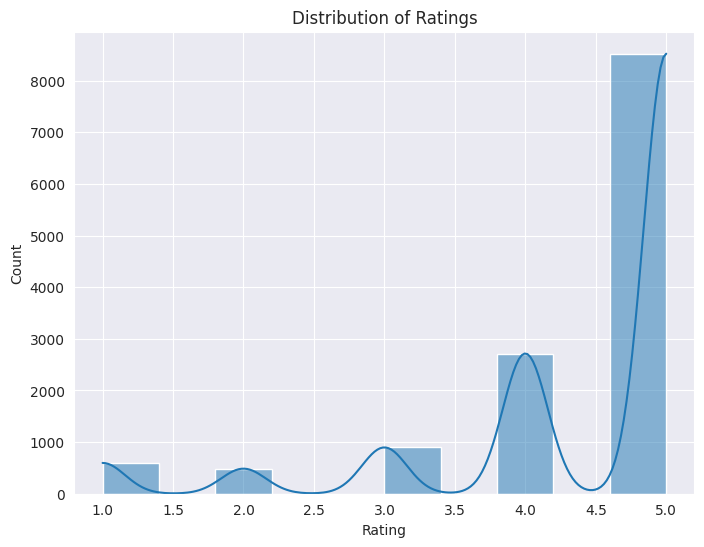

In [14]:
plt.figure(figsize=(8, 6))
sns.histplot(df['rating'].dropna(), bins=10, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

Monthly rating trends

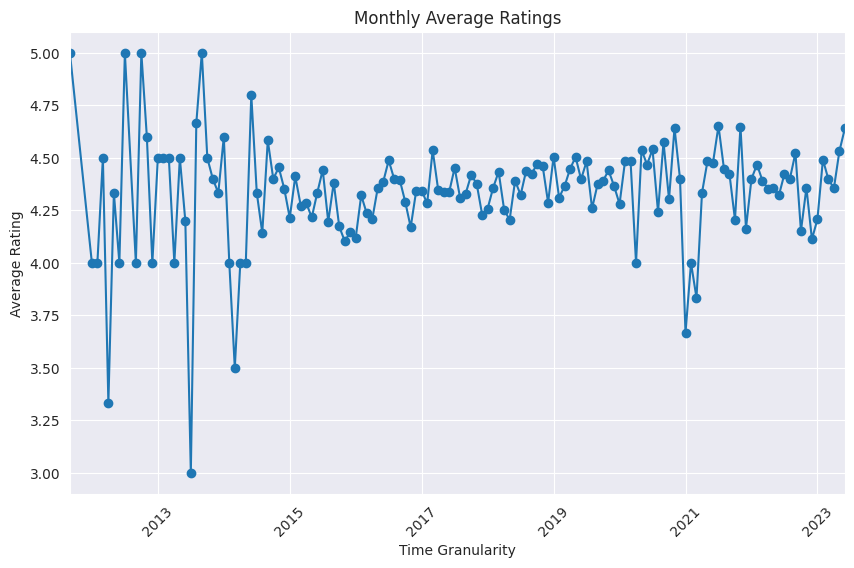

In [15]:
# Monthly rating trends (excluding non-numeric ratings)
df['month'] = df['dateOfReview'].dt.to_period('M')
monthly_ratings = df[df['rating'].notna()].groupby('month')['rating'].mean()
plt.figure(figsize=(10, 6))
monthly_ratings.plot(marker='o')
plt.title("Monthly Average Ratings")
plt.xlabel("Time Granularity")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()

Word cloud of review titles

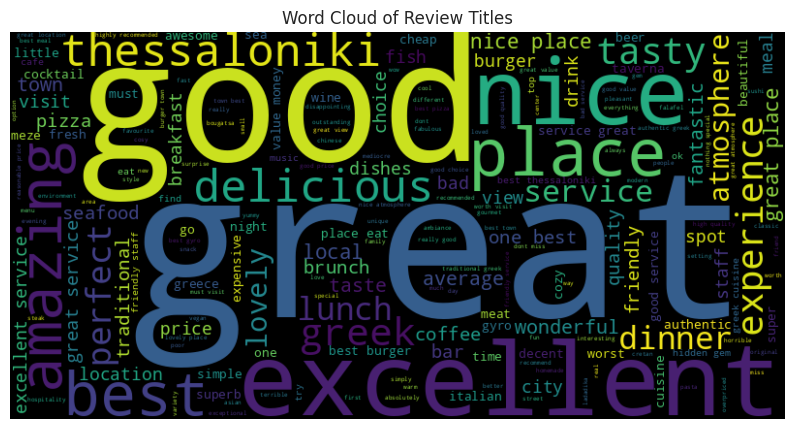

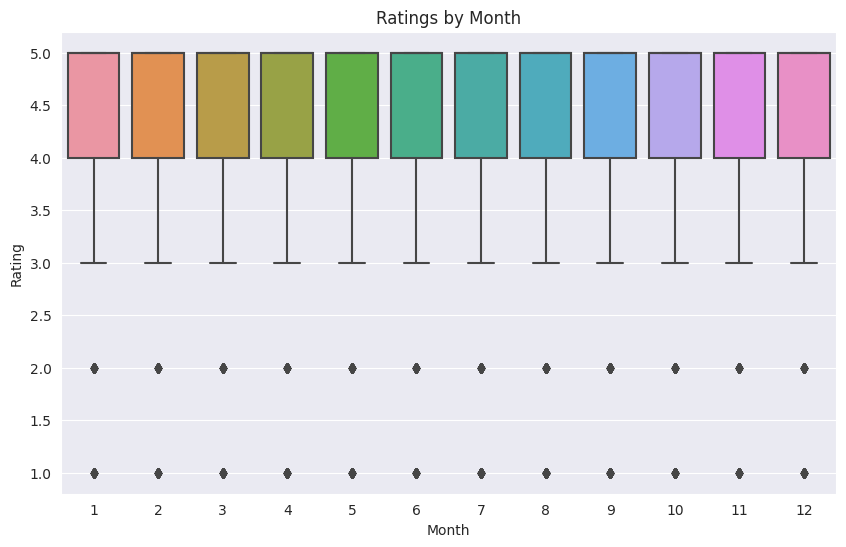

In [16]:
# # Word cloud of review titles
title_text = ' '.join(df['title'].dropna().values)
wordcloud = WordCloud(width=800, height=400).generate(title_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Review Titles")
plt.show()

# Box plot of ratings by month
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['dateOfReview'].dt.month, y=df['rating'].dropna())
plt.title("Ratings by Month")
plt.xlabel("Month")
plt.ylabel("Rating")
plt.show()

Inspection per restaurant

           restaurant  average_rating  total_reviews
0              +trofí        4.833333              6
1          10 to kalo        3.333333              3
2     12 angry breads        4.333333              3
3        22 souvlakia        4.652174             23
4               50-50        5.000000             20
..                ...             ...            ...
844   zythos ladadika        3.750000            172
845       μezedofolia        3.800000             10
846         τo μetoxi        5.000000              5
847  ταβερνα ζαχαριας        4.000000              1
848    τρελα πιρουνια        5.000000              1

[849 rows x 3 columns]
       average_rating  total_reviews
count      849.000000     849.000000
mean         4.392564      15.553592
std          0.707489      39.496713
min          1.000000       1.000000
25%          4.000000       2.000000
50%          4.560976       5.000000
75%          5.000000      14.000000
max          5.000000     692.000000


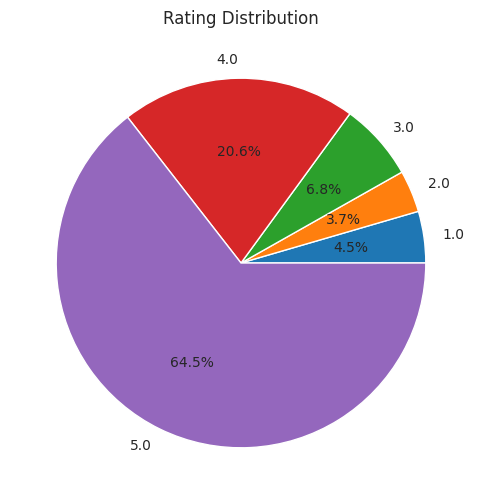

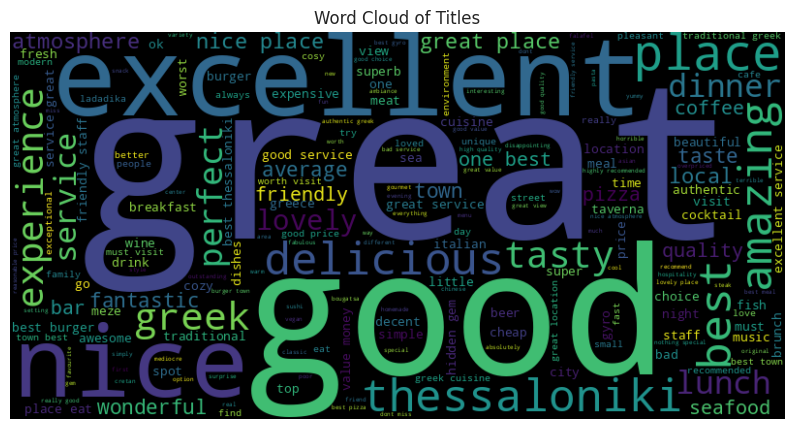

In [17]:
# Step 1: Aggregate the dataframe per restaurant
df_agg_restaurant = df.groupby('restaurant').agg({'rating': 'mean', 'text': 'count'}).reset_index()
df_agg_restaurant.columns = ['restaurant', 'average_rating', 'total_reviews']
print(df_agg_restaurant)
# Step 2: Analyze statistics
restaurant_stats = df_agg_restaurant.describe()
print(restaurant_stats)

# Pie chart of rating distribution
plt.figure(figsize=(6, 6))
labels = ['1.0', '2.0', '3.0', '4.0', '5.0']
sizes = df['rating'].value_counts().sort_index()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Rating Distribution')
plt.show()

Visualization 1 : Visualize the number of monthly reviews over time over all locations. Which was the
month with the most reviews? Is there any seasonality in the volume of reviews?

Option 1

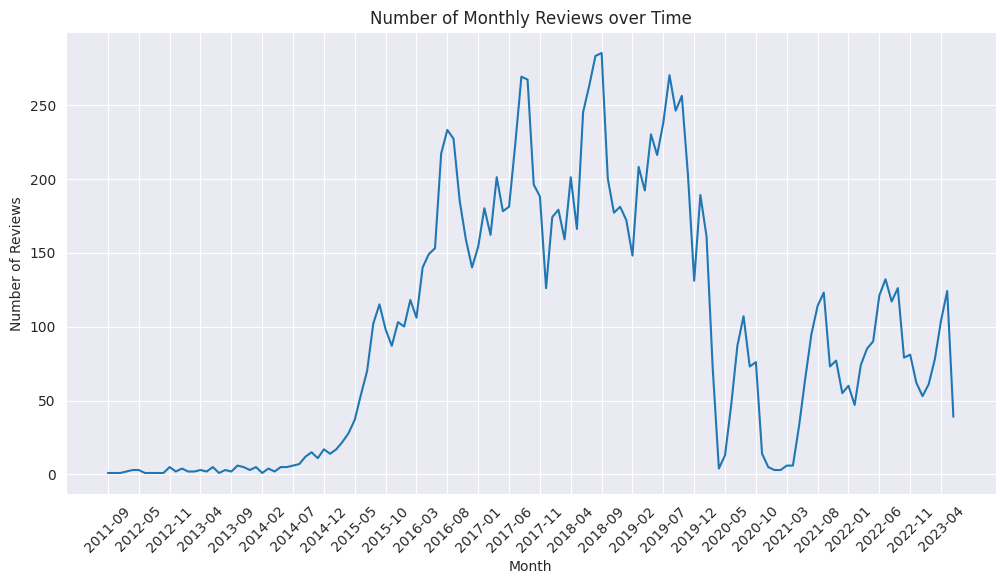

dateOfReview
2018-09    285
2018-08    283
2019-08    270
2017-08    269
2017-09    267
          ... 
2012-07      1
2012-09      1
2012-10      1
2013-07      1
2011-09      1
Length: 138, dtype: int64


In [35]:
#group the data by month & count the number of reviews
monthly_reviews = df.groupby(df['dateOfReview'].dt.to_period('M')).size()
#objects to strings
monthly_reviews.index = monthly_reviews.index.astype(str)

plt.figure(figsize=(12, 6))
plt.plot(monthly_reviews.index, monthly_reviews.values)
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Monthly Reviews over Time')

# x-axis has labels for one of every five dates, otherwise they overlap and are messy
x_ticks = monthly_reviews.index[::5]

plt.gca().set_xticks(x_ticks)
plt.gca().set_xticklabels(x_ticks, rotation=45)

plt.show()

monthly_reviews = monthly_reviews.sort_values(ascending=False)
print(monthly_reviews)

Option 2

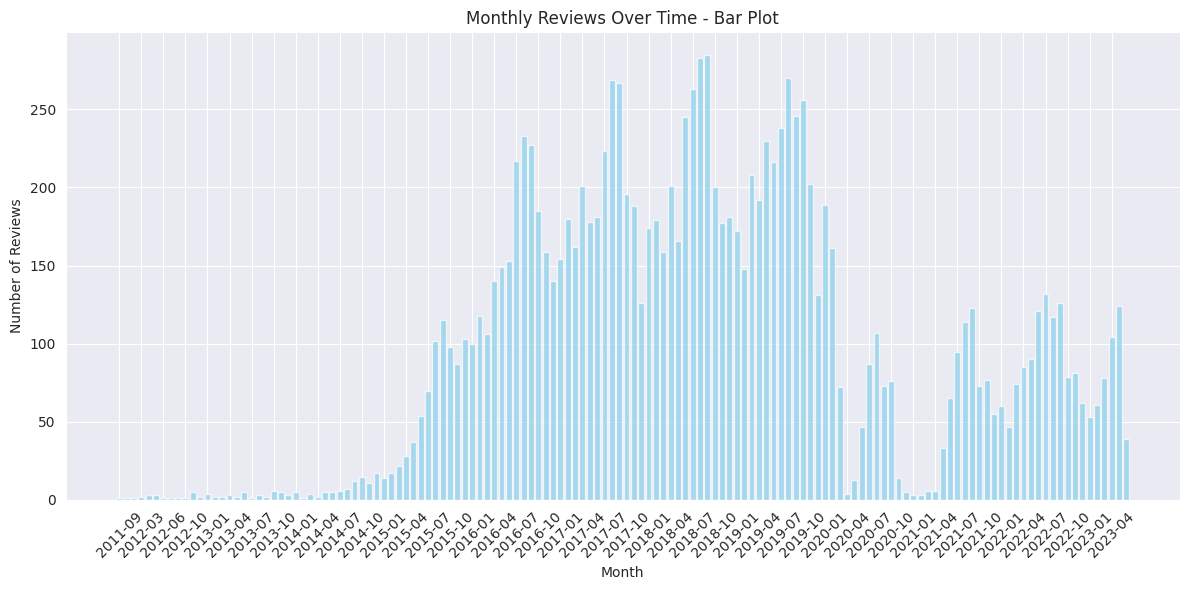

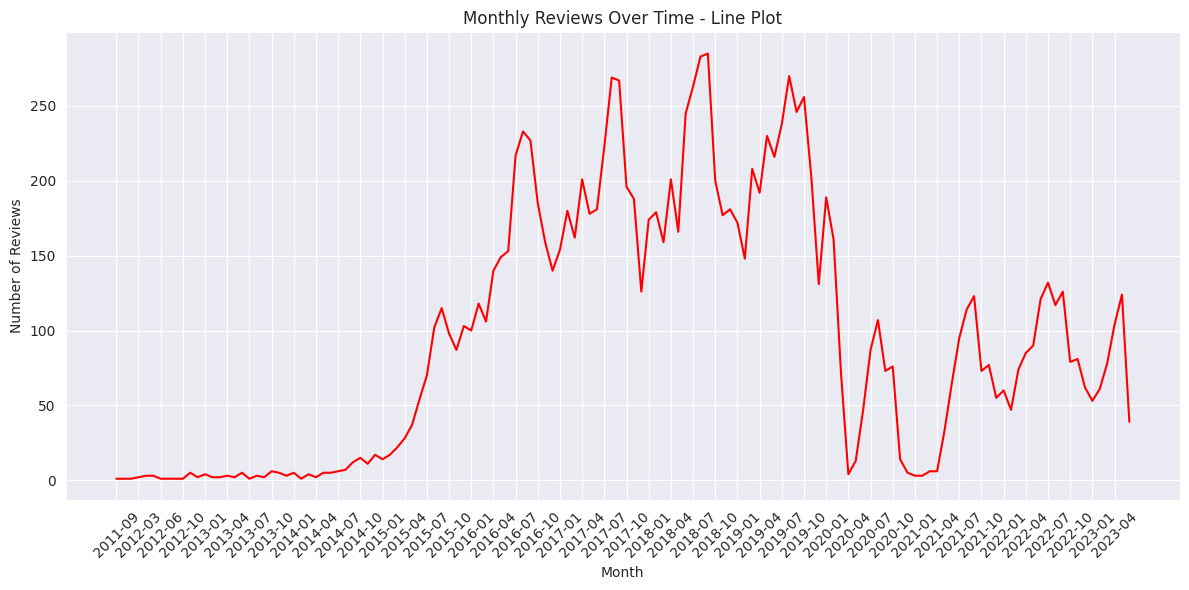

In [36]:
# Convert the 'dateOfReview' column to datetime
df['dateOfReview'] = pd.to_datetime(df['dateOfReview'])

# Extract the month and year from the 'dateOfReview' column
df['month'] = df['dateOfReview'].dt.month
df['year'] = df['dateOfReview'].dt.year

# Group the dataframe by month and year and calculate the number of reviews
monthly_reviews = df.groupby(['year', 'month']).size().reset_index(name='review_count')

# Set the x-ticks to be sparser
x_ticks = monthly_reviews[::3]['year'].astype(str) + '-' + monthly_reviews[::3]['month'].astype(str).str.zfill(2)

# Plot the number of monthly reviews as a bar plot
plt.figure(figsize=(12, 6))
plt.bar(monthly_reviews.index, monthly_reviews['review_count'], color='skyblue', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Monthly Reviews Over Time - Bar Plot')
plt.xticks(monthly_reviews.index[::3], x_ticks, rotation=45)
plt.tight_layout()
plt.show()

# Plot the number of monthly reviews as a line plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_reviews.index, monthly_reviews['review_count'], color='red')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Monthly Reviews Over Time - Line Plot')
plt.xticks(monthly_reviews.index[::3], x_ticks, rotation=45)
plt.tight_layout()
plt.show()



Option 3

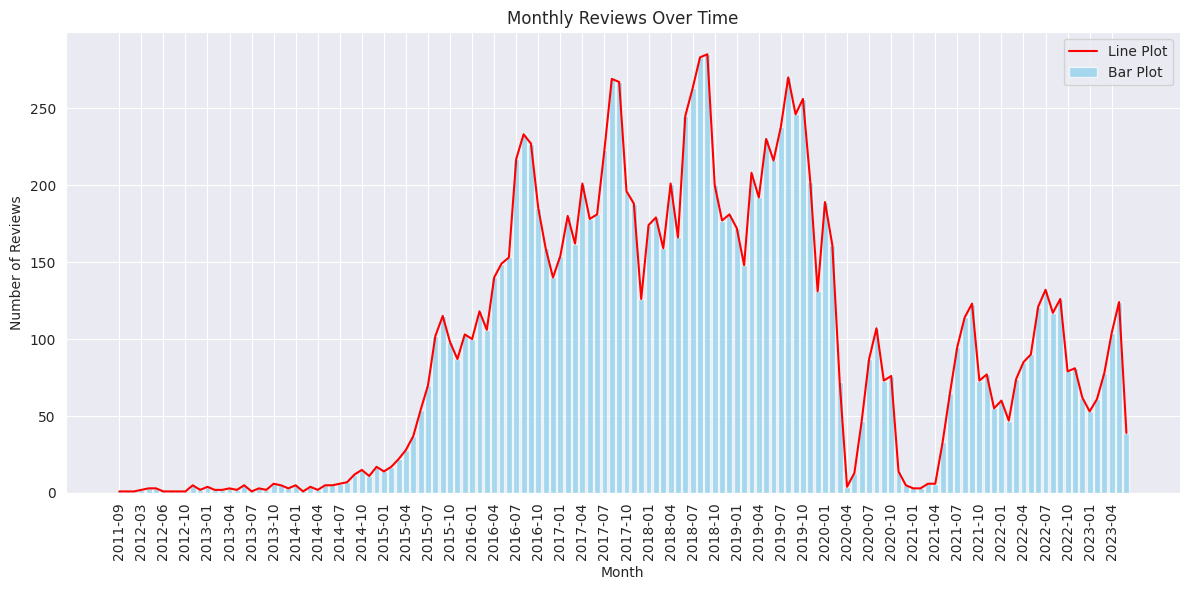

In [37]:
# Convert the 'dateOfReview' column to datetime
df['dateOfReview'] = pd.to_datetime(df['dateOfReview'])

# Extract the month and year from the 'dateOfReview' column
df['month'] = df['dateOfReview'].dt.month
df['year'] = df['dateOfReview'].dt.year

# Group the dataframe by month and year and calculate the number of reviews
monthly_reviews = df.groupby(['year', 'month']).size().reset_index(name='review_count')

# Set the x-ticks to be sparser
x_ticks = monthly_reviews[::3]['year'].astype(str) + '-' + monthly_reviews[::3]['month'].astype(str).str.zfill(2)

# Plot the number of monthly reviews as a line plot and a bar plot
plt.figure(figsize=(12, 6))

plt.plot(monthly_reviews.index, monthly_reviews['review_count'], color='red', label='Line Plot')
plt.bar(monthly_reviews.index, monthly_reviews['review_count'], color='skyblue', alpha=0.7, label='Bar Plot')

plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Monthly Reviews Over Time')
plt.xticks(monthly_reviews.index[::3], x_ticks, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


Visualization 2: Which are the top-10 rated and the bottom-10 rated locations? Consider a
combination of the number of ratings for a location and the rating itself for validity.

Option 1

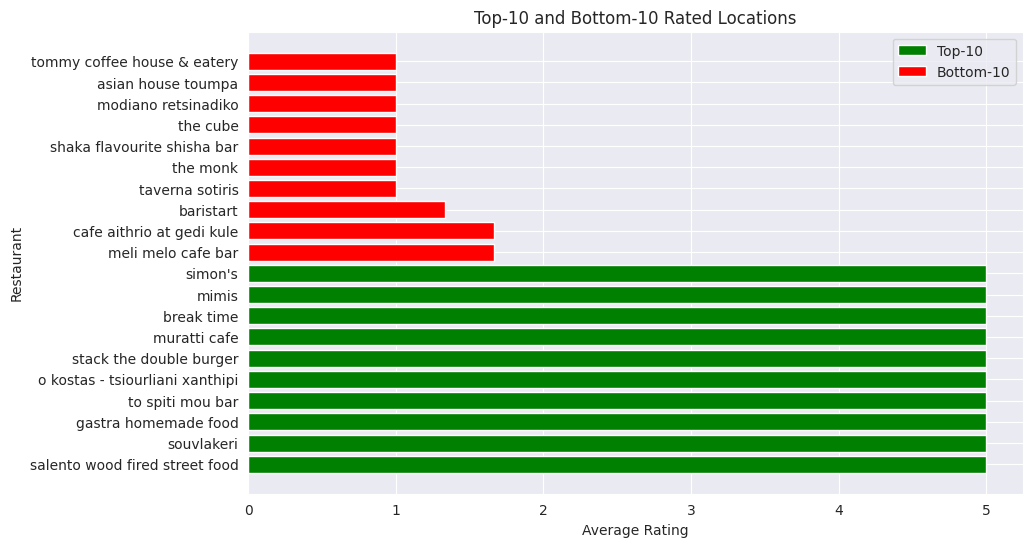

In [21]:
restaurants = df['restaurant'].unique()

#average rating for each restaurant
average_ratings = []
for restaurant in restaurants:
    ratings = df[df['restaurant'] == restaurant]['rating'].astype(float)  # Convert ratings to float
    average_rating = ratings.sum() / ratings.count()
    average_ratings.append({'Restaurant': restaurant, 'Average Rating': average_rating})

restaurant_stats = pd.DataFrame(average_ratings)

restaurant_stats_sorted = restaurant_stats.sort_values('Average Rating', ascending=False)

#select top-10 & bottom-10 rated locations
top_10_locations = restaurant_stats_sorted.head(10)
bottom_10_locations = restaurant_stats_sorted.tail(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_10_locations['Restaurant'], top_10_locations['Average Rating'], color='green', label='Top-10')
plt.barh(bottom_10_locations['Restaurant'], bottom_10_locations['Average Rating'], color='red', label='Bottom-10')
plt.xlabel('Average Rating')
plt.ylabel('Restaurant')
plt.title('Top-10 and Bottom-10 Rated Locations')
plt.legend()
plt.show()

Option 2 (with reviews filtering: Consider only restaurants that have at least 20% total reviews of the mean count of the total reviews in our dataset)

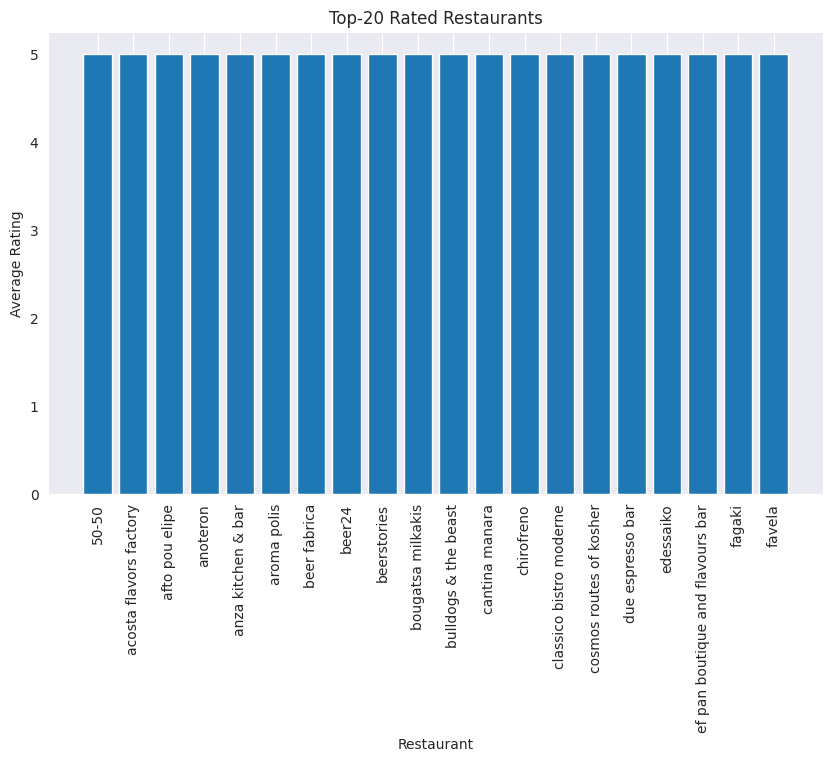

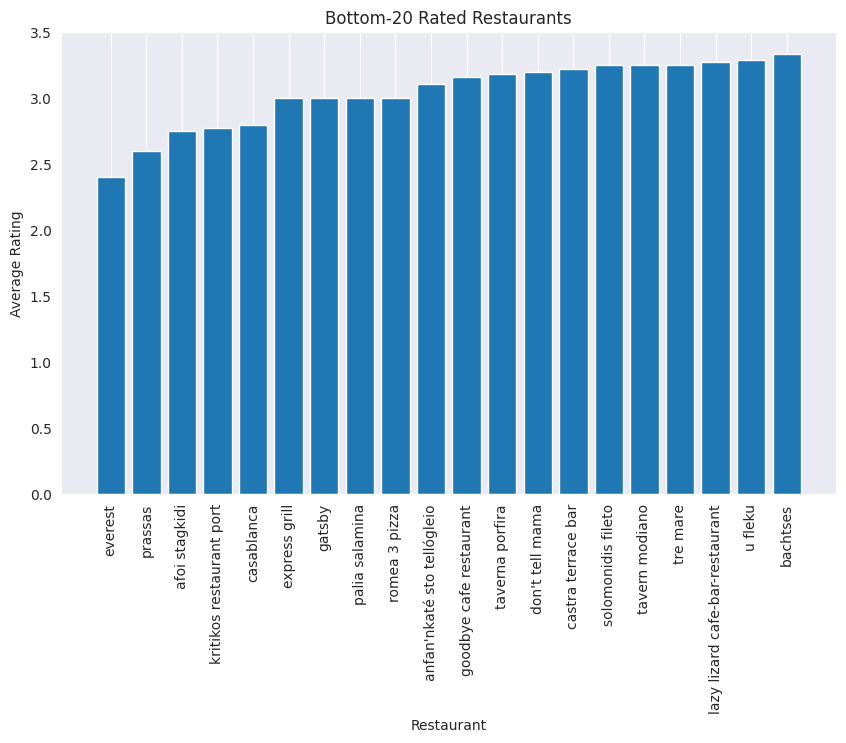

In [22]:
# Convert the 'rating' column to numeric dtype
df['rating'] = pd.to_numeric(df['rating'])

# Calculate the mean count of reviews for all restaurants
mean_review_count = df['restaurant'].value_counts().mean()

# Filter out restaurants with less than 20% of the mean count of reviews
valid_restaurants = df.groupby('restaurant').filter(lambda x: len(x) >= 0.2 * mean_review_count)

# Calculate the average rating for each restaurant
restaurant_ratings = valid_restaurants.groupby('restaurant')['rating'].mean()

# Get the top-10 rated restaurants
top_20_restaurants = restaurant_ratings.nlargest(20)

# Get the bottom-10 rated restaurants
bottom_20_restaurants = restaurant_ratings.nsmallest(20)

# Plotting the top-10 rated restaurants
plt.figure(figsize=(10, 6))
plt.bar(top_20_restaurants.index, top_20_restaurants.values)
plt.title('Top-20 Rated Restaurants')
plt.xlabel('Restaurant')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

# Plotting the bottom-10 rated restaurants
plt.figure(figsize=(10, 6))
plt.bar(bottom_20_restaurants.index, bottom_20_restaurants.values)
plt.title('Bottom-20 Rated Restaurants')
plt.xlabel('Restaurant')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()


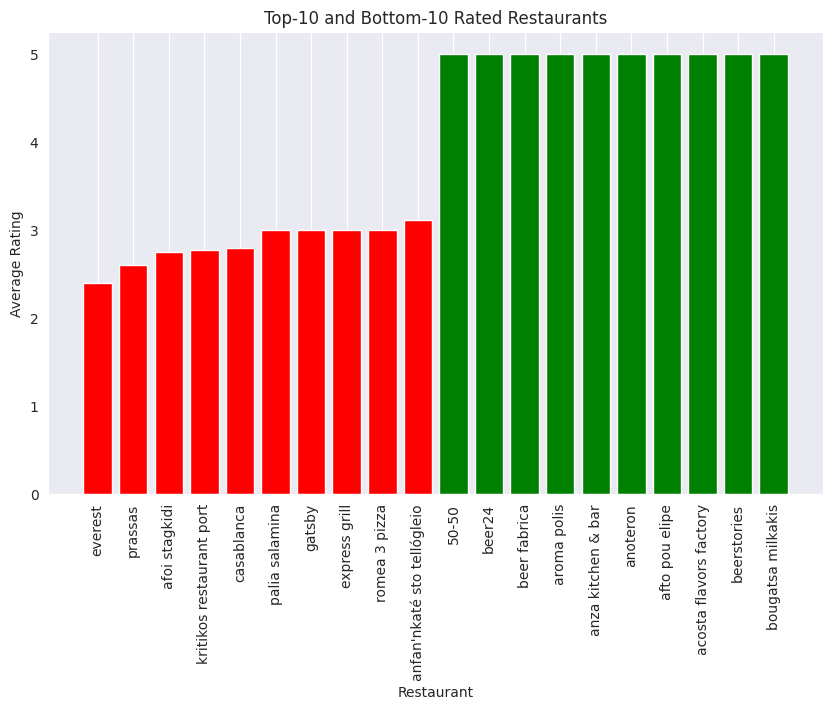

In [23]:
# Convert the 'rating' column to numeric dtype
df['rating'] = pd.to_numeric(df['rating'])

# Calculate the mean count of reviews for all restaurants
mean_review_count = df['restaurant'].value_counts().mean()

# Filter out restaurants with less than 20% of the mean count of reviews
valid_restaurants = df.groupby('restaurant').filter(lambda x: len(x) >= 0.2 * mean_review_count)

# Calculate the average rating for each restaurant
restaurant_ratings = valid_restaurants.groupby('restaurant')['rating'].mean()

# Get the top-10 rated restaurants
top_10_restaurants = restaurant_ratings.nlargest(10)

# Get the bottom-10 rated restaurants
bottom_10_restaurants = restaurant_ratings.nsmallest(10)

# Create a new DataFrame for plotting
plot_data = pd.concat([top_10_restaurants, bottom_10_restaurants])
plot_data.sort_values(inplace=True)

# Create a color list for the bars
colors = ['red'] * len(bottom_10_restaurants) + ['green'] * len(top_10_restaurants)

# Plotting the top-10 and bottom-10 rated restaurants
plt.figure(figsize=(10, 6))
plt.bar(plot_data.index, plot_data.values, color=colors)
plt.title('Top-10 and Bottom-10 Rated Restaurants')
plt.xlabel('Restaurant')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()


Visualization 3: Which locations have the highest increase or decrease in rating over the years?
Consider calculating the yearly average and percentage change per location.

Option 1

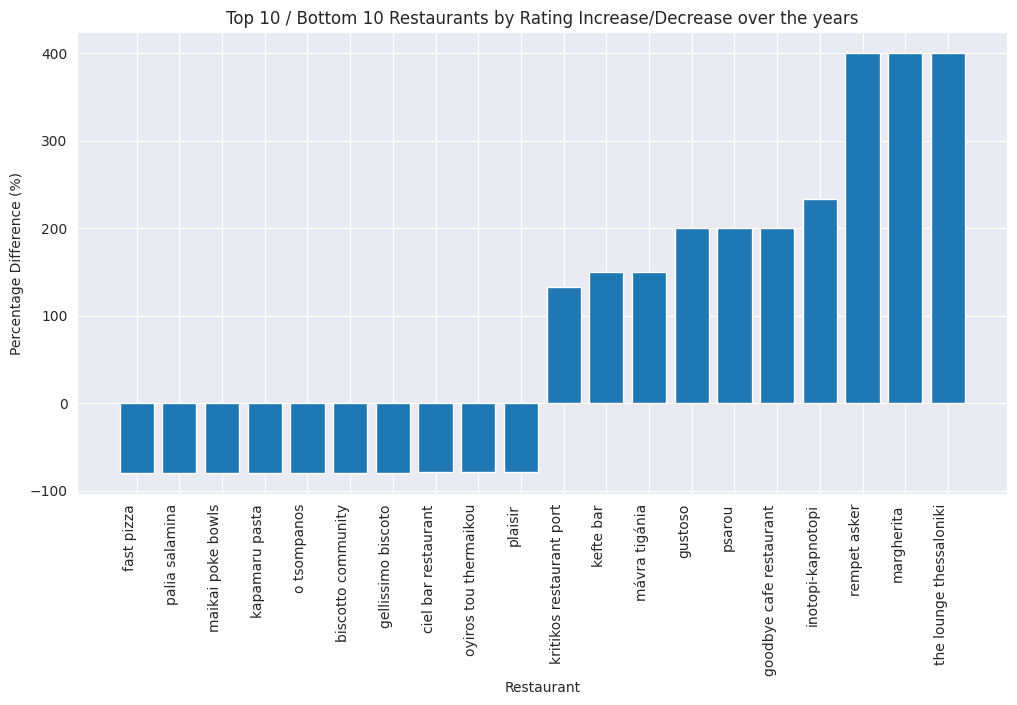

In [24]:
#Convert dateOfReview column to datetime
df['dateOfReview'] = pd.to_datetime(df['dateOfReview'])

df['Year'] = df['dateOfReview'].dt.year

#convert 'rating' column to numeric
df['rating'] = pd.to_numeric(df['rating'])

#group by restaurant and year, calculate average rating, and create a new DataFrame
df_avg_ratings = df.groupby(['restaurant', 'Year'])['rating'].mean().reset_index()
df_pivot = df_avg_ratings.pivot(index='restaurant', columns='Year', values='rating')

#remove any NaN values and create a new column with a list of average ratings per restaurant
df_pivot['avg_ratings'] = df_pivot.apply(lambda row: row.dropna().values.tolist(), axis=1)

df_pivot = df_pivot.reset_index().rename(columns={'restaurant': 'Restaurant'})

def calculate_percentage_difference(lst):
    if len(lst) >= 2:
        first_element = lst[0]
        last_element = lst[-1]
        percentage_difference = ((last_element - first_element) / first_element) * 100
        return percentage_difference
    else:
        return None

#new column with the percentage difference
df_pivot['percentage_diff'] = df_pivot['avg_ratings'].apply(calculate_percentage_difference)

# print(df_pivot)


#replace NaN values with 0 in the 'percentage_diff' column
df_pivot['percentage_diff'].fillna(0, inplace=True)

df_pivot_sorted = df_pivot.sort_values('percentage_diff')
# print(df_pivot_sorted.head(10))
# print(df_pivot_sorted.tail(10))
top_10 = df_pivot_sorted.head(10)
bottom_10 = df_pivot_sorted.tail(10)

plot_data = pd.concat([top_10, bottom_10])

plt.figure(figsize=(12, 6))
plt.bar(plot_data['Restaurant'], plot_data['percentage_diff'])
plt.xlabel('Restaurant')
plt.ylabel('Percentage Difference (%)')
plt.title('Top 10 / Bottom 10 Restaurants by Rating Increase/Decrease over the years')
plt.xticks(rotation=90, ha='right')
plt.show()

Option 2

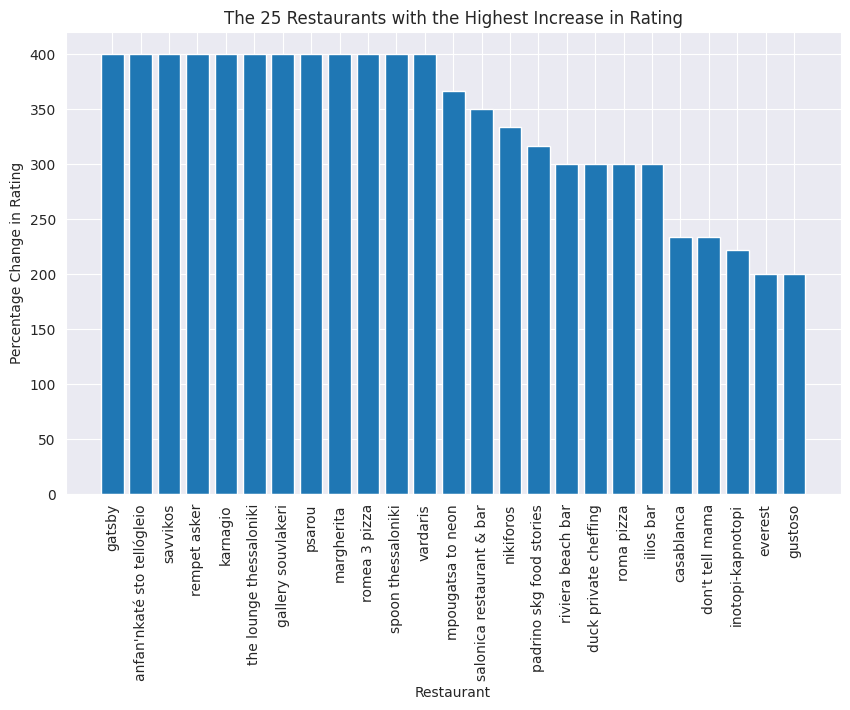

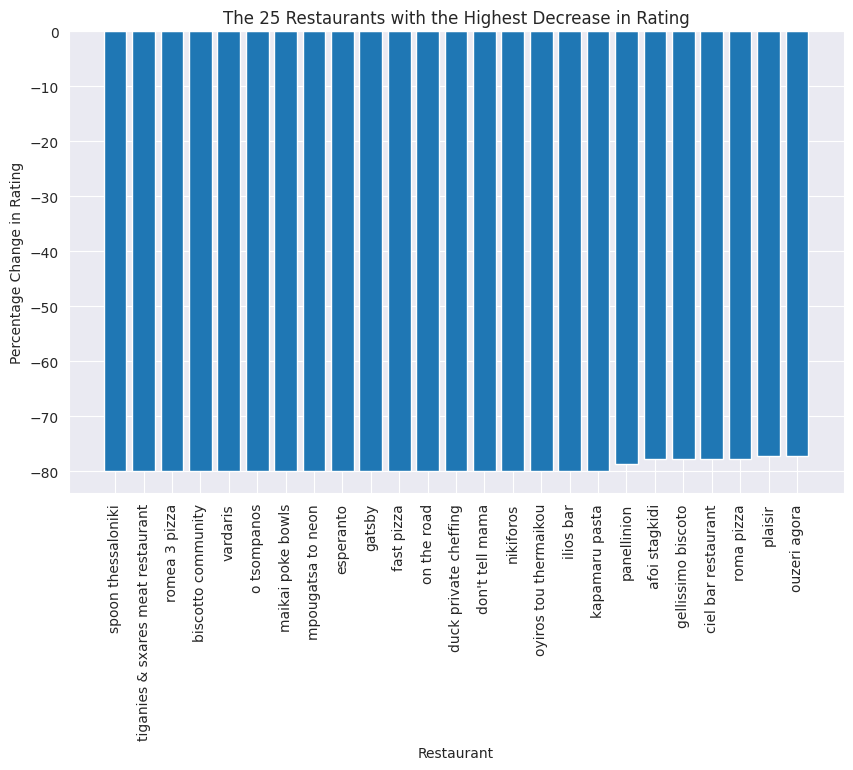

In [25]:
# Group the dataframe by location and year
grouped_df = df.groupby(['restaurant', df['dateOfReview'].dt.year])

# Calculate the average rating per year for each location
yearly_avg_rating = grouped_df['rating'].mean().reset_index()

# Calculate the percentage change in rating from year to year for each location
yearly_avg_rating['percentage_change'] = yearly_avg_rating.groupby('restaurant')['rating'].pct_change() * 100
# print(yearly_avg_rating['percentage_change'])
# Find the locations with the highest increase and decrease in rating
highest_increase = yearly_avg_rating.sort_values('percentage_change', ascending=False).head(25)
# print(yearly_avg_rating.sort_values('percentage_change', ascending=False).head(15))
highest_decrease = yearly_avg_rating.sort_values('percentage_change').head(25)
# print(yearly_avg_rating.sort_values('percentage_change').head(15))
# Plotting the locations with the highest increase in rating
plt.figure(figsize=(10, 6))
plt.bar(highest_increase['restaurant'], highest_increase['percentage_change'])
plt.title('The 25 Restaurants with the Highest Increase in Rating')
plt.xlabel('Restaurant')
plt.ylabel('Percentage Change in Rating')
plt.xticks(rotation=90)
plt.show()

# Plotting the locations with the highest decrease in rating
plt.figure(figsize=(10, 6))
plt.bar(highest_decrease['restaurant'], highest_decrease['percentage_change'])
plt.title('The 25 Restaurants with the Highest Decrease in Rating')
plt.xlabel('Restaurant')
plt.ylabel('Percentage Change in Rating')
plt.xticks(rotation=90)
plt.show()


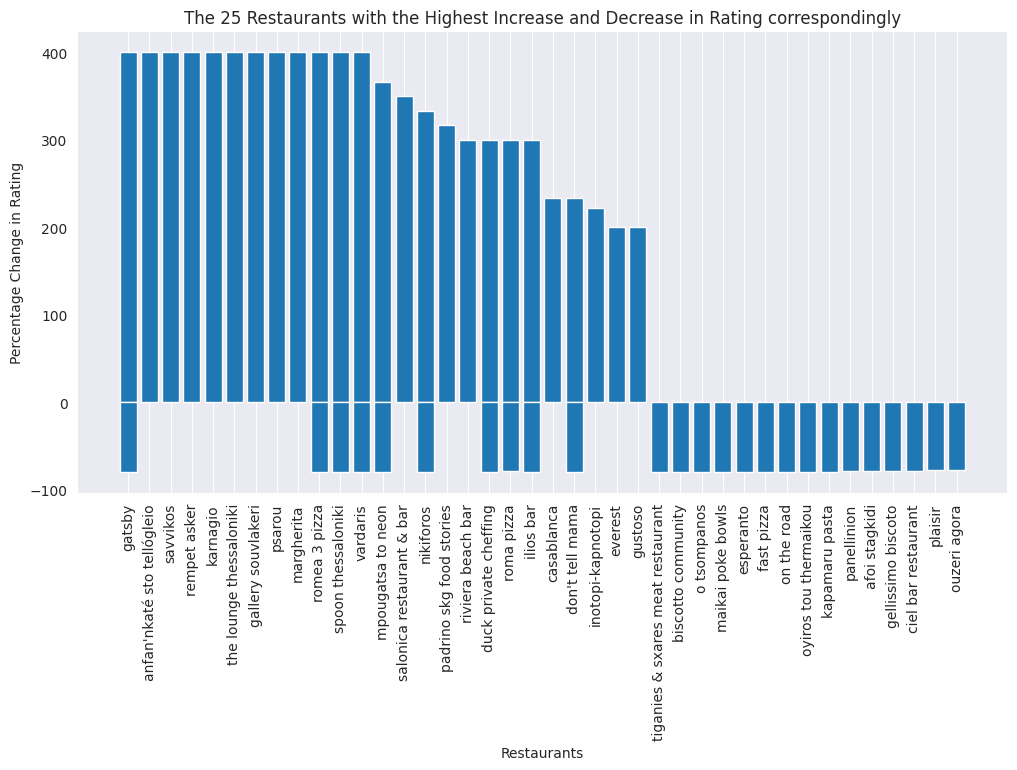

In [26]:
# Group the dataframe by location and year
grouped_df = df.groupby(['restaurant', df['dateOfReview'].dt.year])

# Calculate the average rating per year for each location
yearly_avg_rating = grouped_df['rating'].mean().reset_index()

# Calculate the percentage change in rating from year to year for each location
yearly_avg_rating['percentage_change'] = yearly_avg_rating.groupby('restaurant')['rating'].pct_change() * 100

# Find the locations with the highest increase and decrease in rating
highest_increase = yearly_avg_rating.sort_values('percentage_change', ascending=False).head(25)
highest_decrease = yearly_avg_rating.sort_values('percentage_change').head(25)

# Merge the highest increase and decrease dataframes
merged_data = pd.concat([highest_increase, highest_decrease])

# Plotting the locations with the highest increase and decrease in rating
plt.figure(figsize=(12, 6))
plt.bar(merged_data['restaurant'], merged_data['percentage_change'])
plt.title('The 25 Restaurants with the Highest Increase and Decrease in Rating correspondingly')
plt.xlabel('Restaurants')
plt.ylabel('Percentage Change in Rating')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()


Visualization 4: Visualize the most common words, bi-grams, and tri-grams across all reviews through a bar chart or word cloud. Also, visualize the most common words, bi-grams, and tri-grams in 5-star versus 1-star reviews.

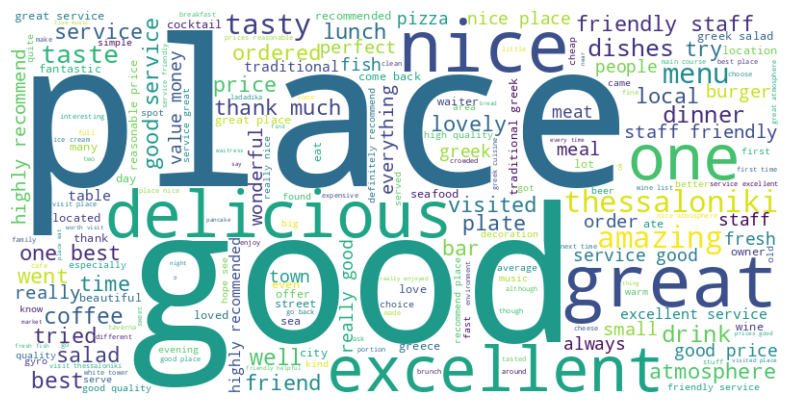

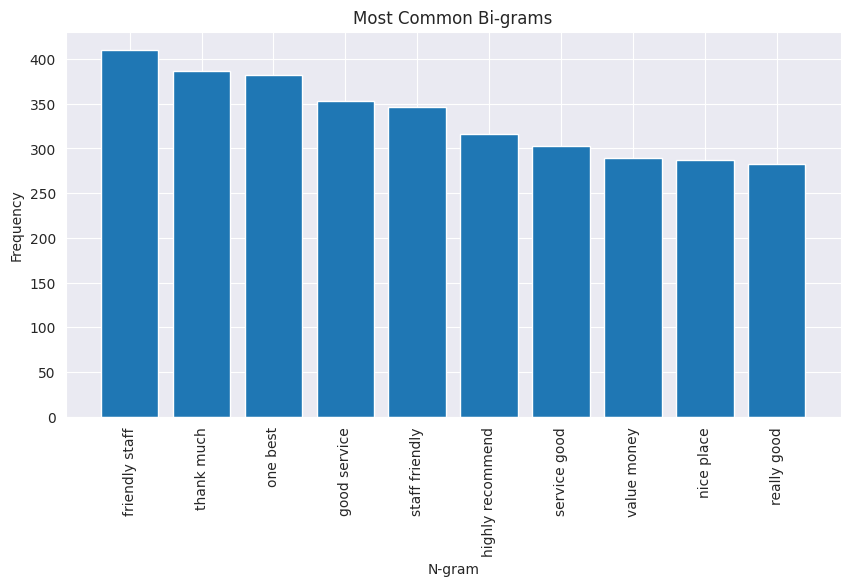

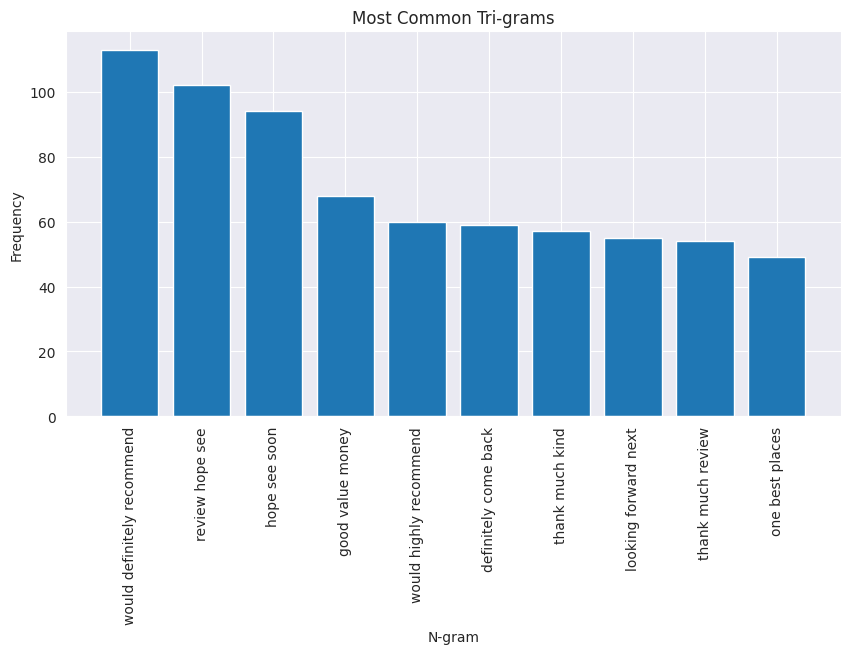

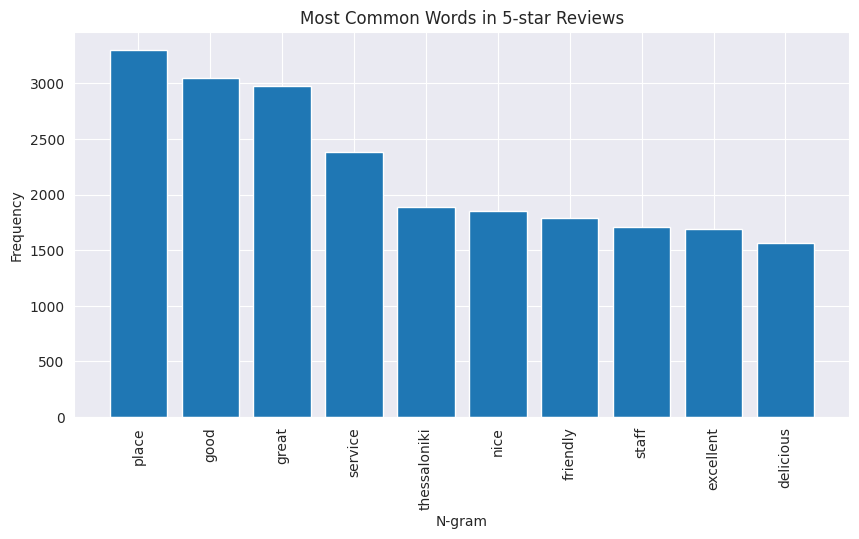

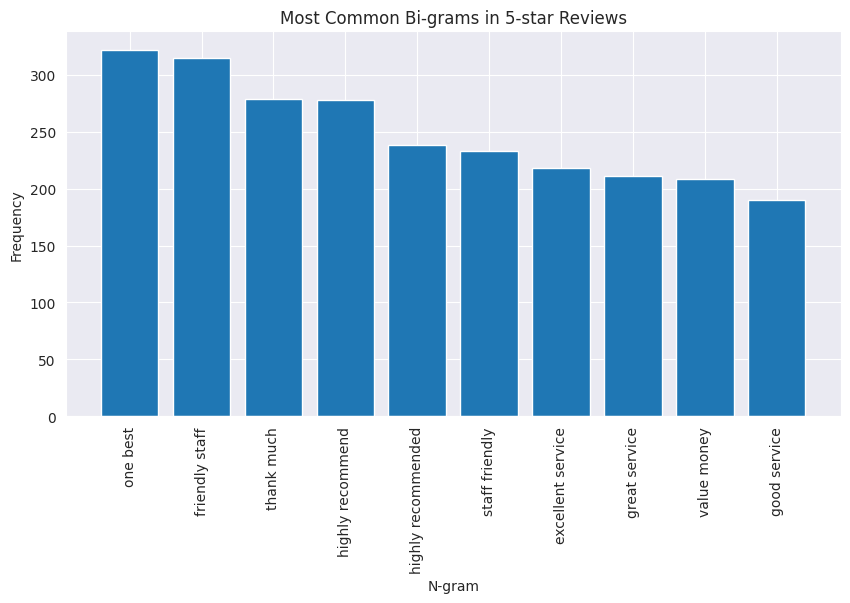

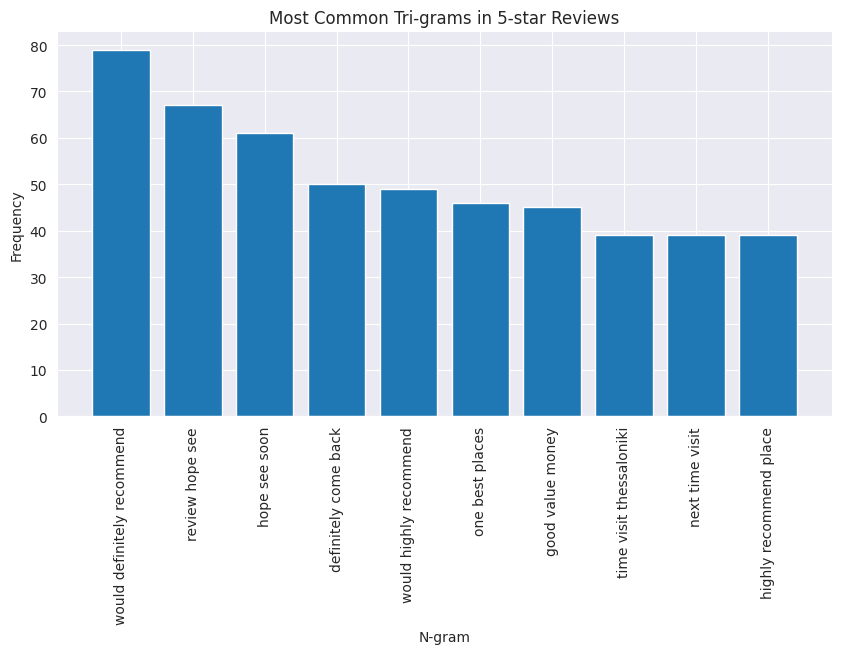

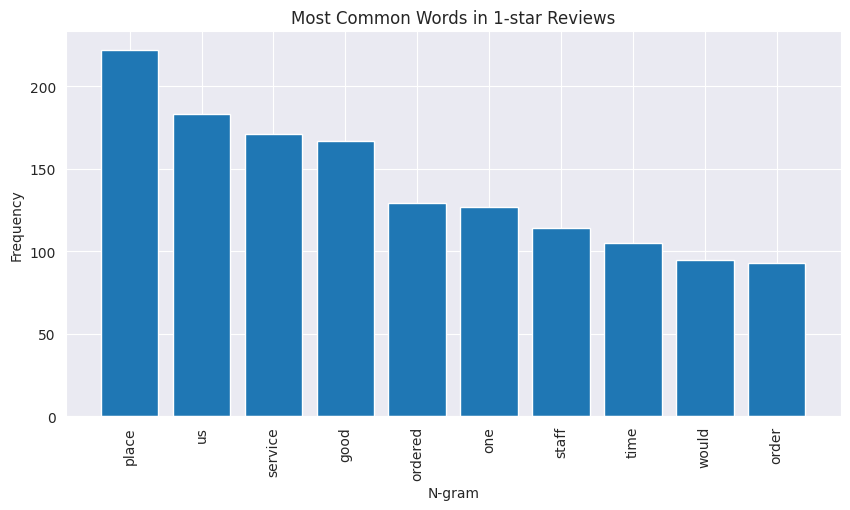

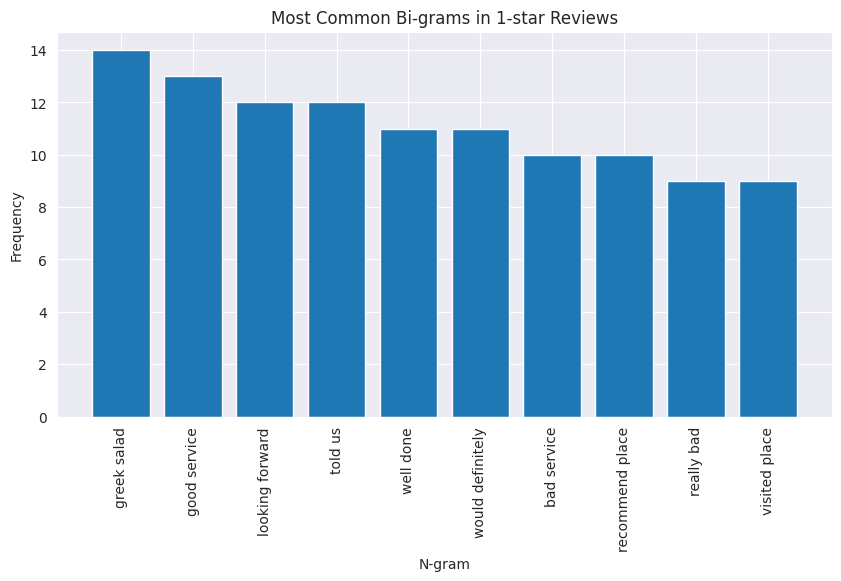

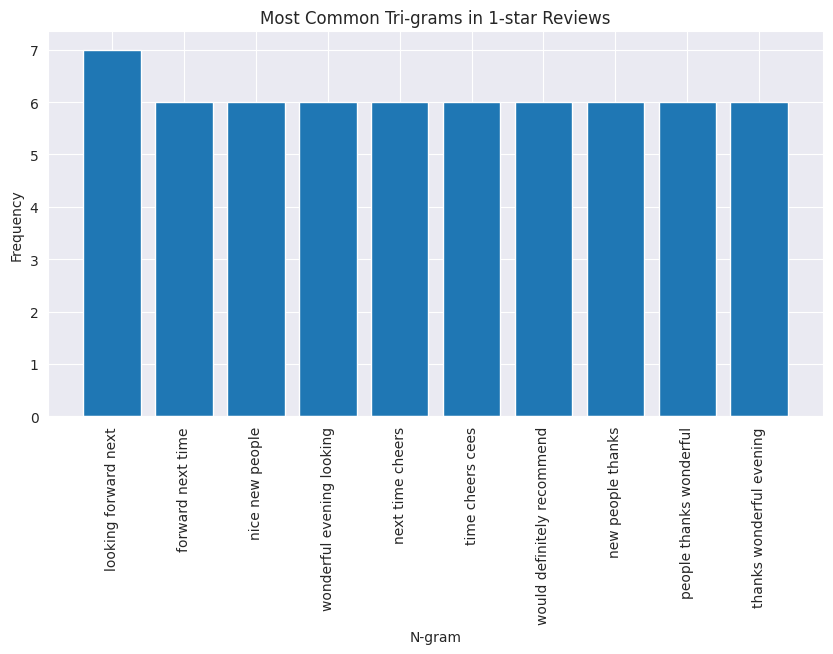

In [27]:
# Create a function to generate word clouds
def generate_word_cloud(data):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Combine all reviews' text into a single string
all_reviews_text = df['text'].tolist()
# print(all_reviews_text)
# Generate a word cloud for the most common words across all reviews
generate_word_cloud(all_reviews_text)

# Separate the 5-star and 1-star reviews
five_star_reviews = df[df['rating'] == 5]['text'].tolist()
one_star_reviews = df[df['rating'] == 1]['text'].tolist()

# Create a function to generate n-grams and plot their frequencies
def generate_ngrams_plot(data, n, title):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(data)
    ngrams = vectorizer.get_feature_names_out()
    ngram_counts = X.toarray().sum(axis=0)
    df_ngrams = pd.DataFrame({'ngram': ngrams, 'count': ngram_counts})
    df_ngrams = df_ngrams.sort_values('count', ascending=False).head(10)
    plt.figure(figsize=(10, 5))
    plt.bar(df_ngrams['ngram'], df_ngrams['count'])
    plt.title(title)
    plt.xlabel('N-gram')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

# Generate and plot the most common bi-grams and tri-grams across all reviews
generate_ngrams_plot(all_reviews_text, 2, 'Most Common Bi-grams')
generate_ngrams_plot(all_reviews_text, 3, 'Most Common Tri-grams')

# Generate and plot the most common words, bi-grams, and tri-grams in 5-star reviews
generate_ngrams_plot(five_star_reviews, 1, 'Most Common Words in 5-star Reviews')
generate_ngrams_plot(five_star_reviews, 2, 'Most Common Bi-grams in 5-star Reviews')
generate_ngrams_plot(five_star_reviews, 3, 'Most Common Tri-grams in 5-star Reviews')

# Generate and plot the most common words, bi-grams, and tri-grams in 1-star reviews
generate_ngrams_plot(one_star_reviews, 1, 'Most Common Words in 1-star Reviews')
generate_ngrams_plot(one_star_reviews, 2, 'Most Common Bi-grams in 1-star Reviews')
generate_ngrams_plot(one_star_reviews, 3, 'Most Common Tri-grams in 1-star Reviews')


1-star reviews vs 5-star reviews in the same plot

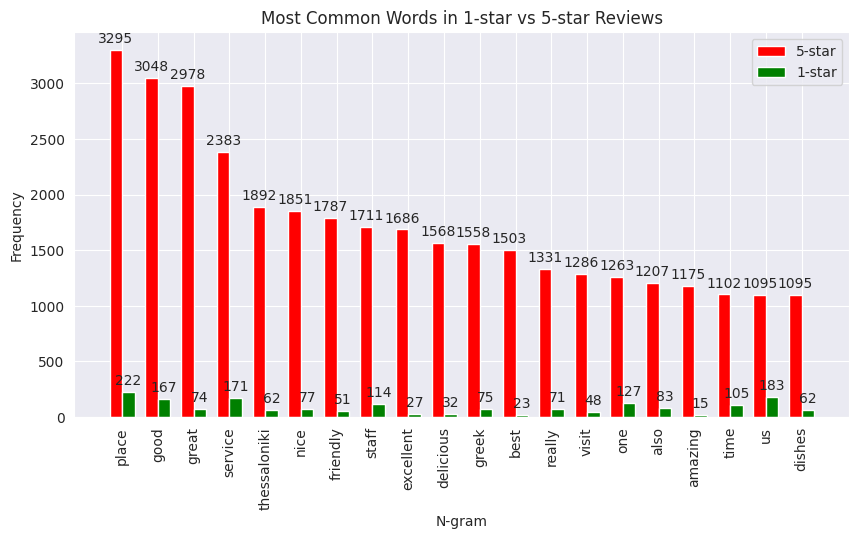

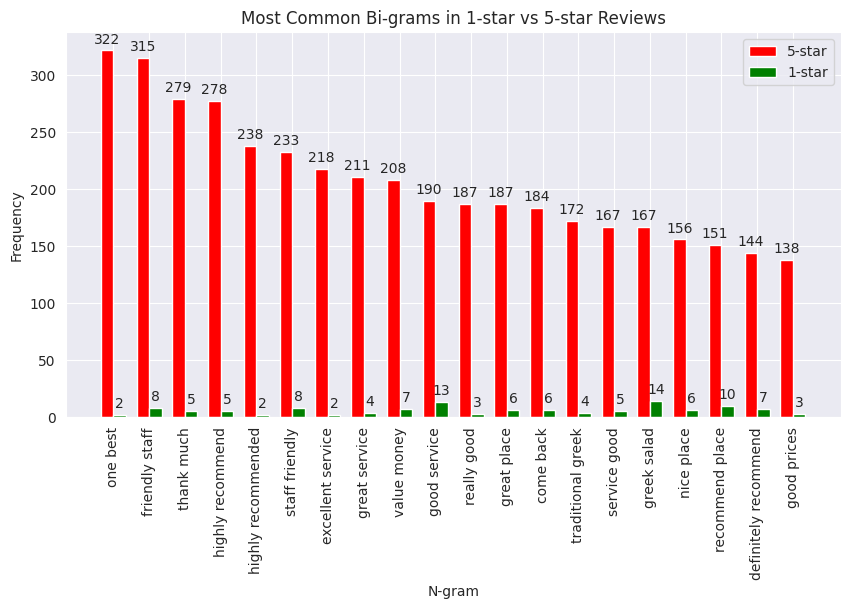

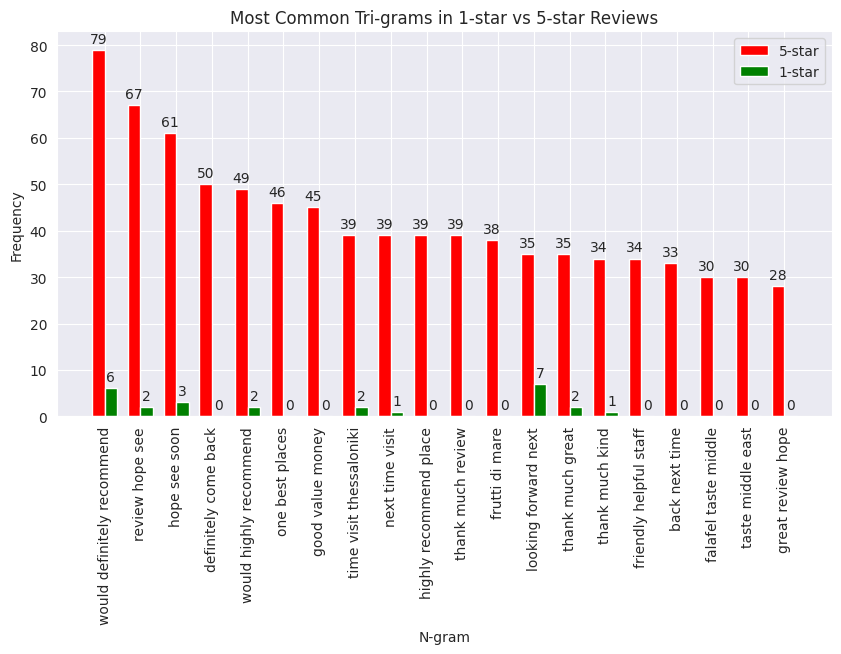

In [28]:
# Create a function to generate n-grams and plot their frequencies with different colors
def generate_ngrams_plot(data1, data2, n, title):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X1 = vectorizer.fit_transform(data1)
    X2 = vectorizer.transform(data2)
    ngrams = vectorizer.get_feature_names_out()
    ngram_counts1 = X1.toarray().sum(axis=0)
    ngram_counts2 = X2.toarray().sum(axis=0)

    df_ngrams = pd.DataFrame({'ngram': ngrams, 'count1': ngram_counts1, 'count2': ngram_counts2})
    df_ngrams = df_ngrams.sort_values('count1', ascending=False).head(20)

    x = np.arange(len(df_ngrams))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x - width/2, df_ngrams['count1'], width, label='5-star', color='red')
    rects2 = ax.bar(x + width/2, df_ngrams['count2'], width, label='1-star', color='green')

    ax.set_title(title)
    ax.set_xlabel('N-gram')
    ax.set_ylabel('Frequency')
    ax.set_xticks(x)
    ax.set_xticklabels(df_ngrams['ngram'], rotation=90)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{int(height)}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.show()


# Generate and plot the most common words, bi-grams, and tri-grams in 1-star vs 5-star reviews
generate_ngrams_plot(five_star_reviews, one_star_reviews, 1, 'Most Common Words in 1-star vs 5-star Reviews')
generate_ngrams_plot(five_star_reviews, one_star_reviews, 2, 'Most Common Bi-grams in 1-star vs 5-star Reviews')
generate_ngrams_plot(five_star_reviews, one_star_reviews, 3, 'Most Common Tri-grams in 1-star vs 5-star Reviews')

Visualization 5: Which are the 10 fastest growing and the 10 fastest shrinking words (based on usage
frequency) in TripAdvisor reviews over time? See here for an example.

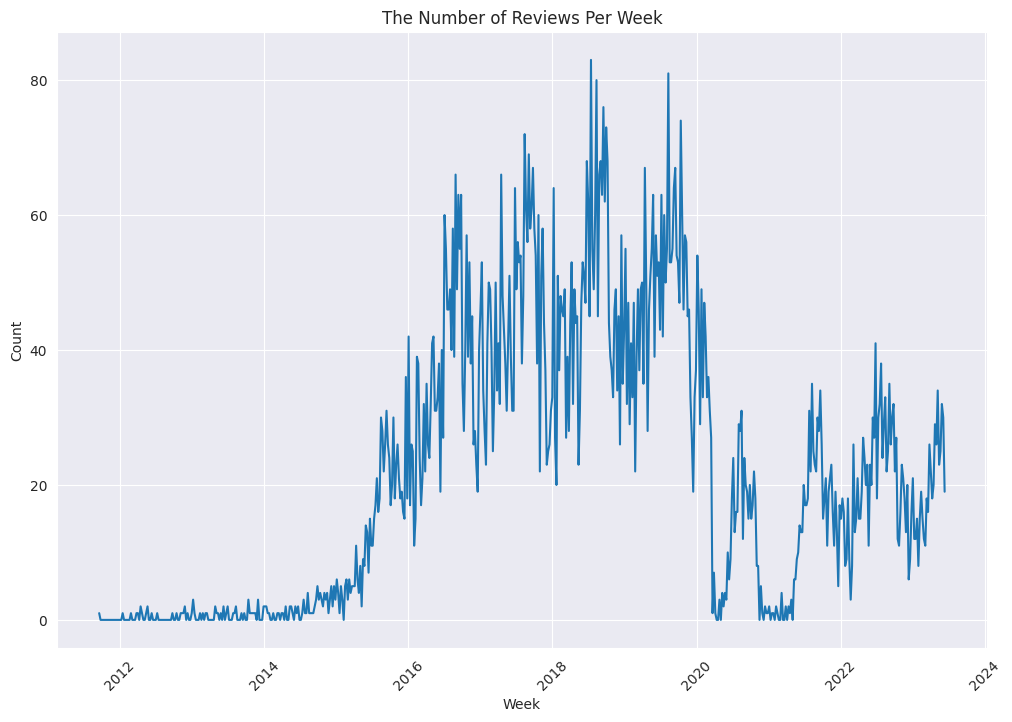

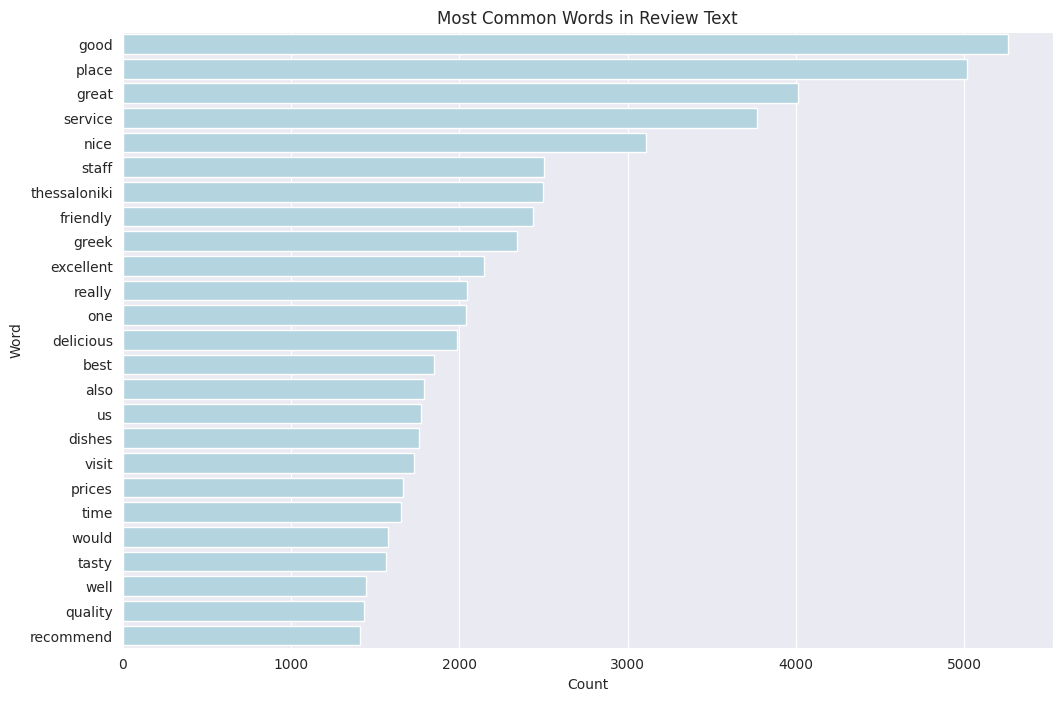

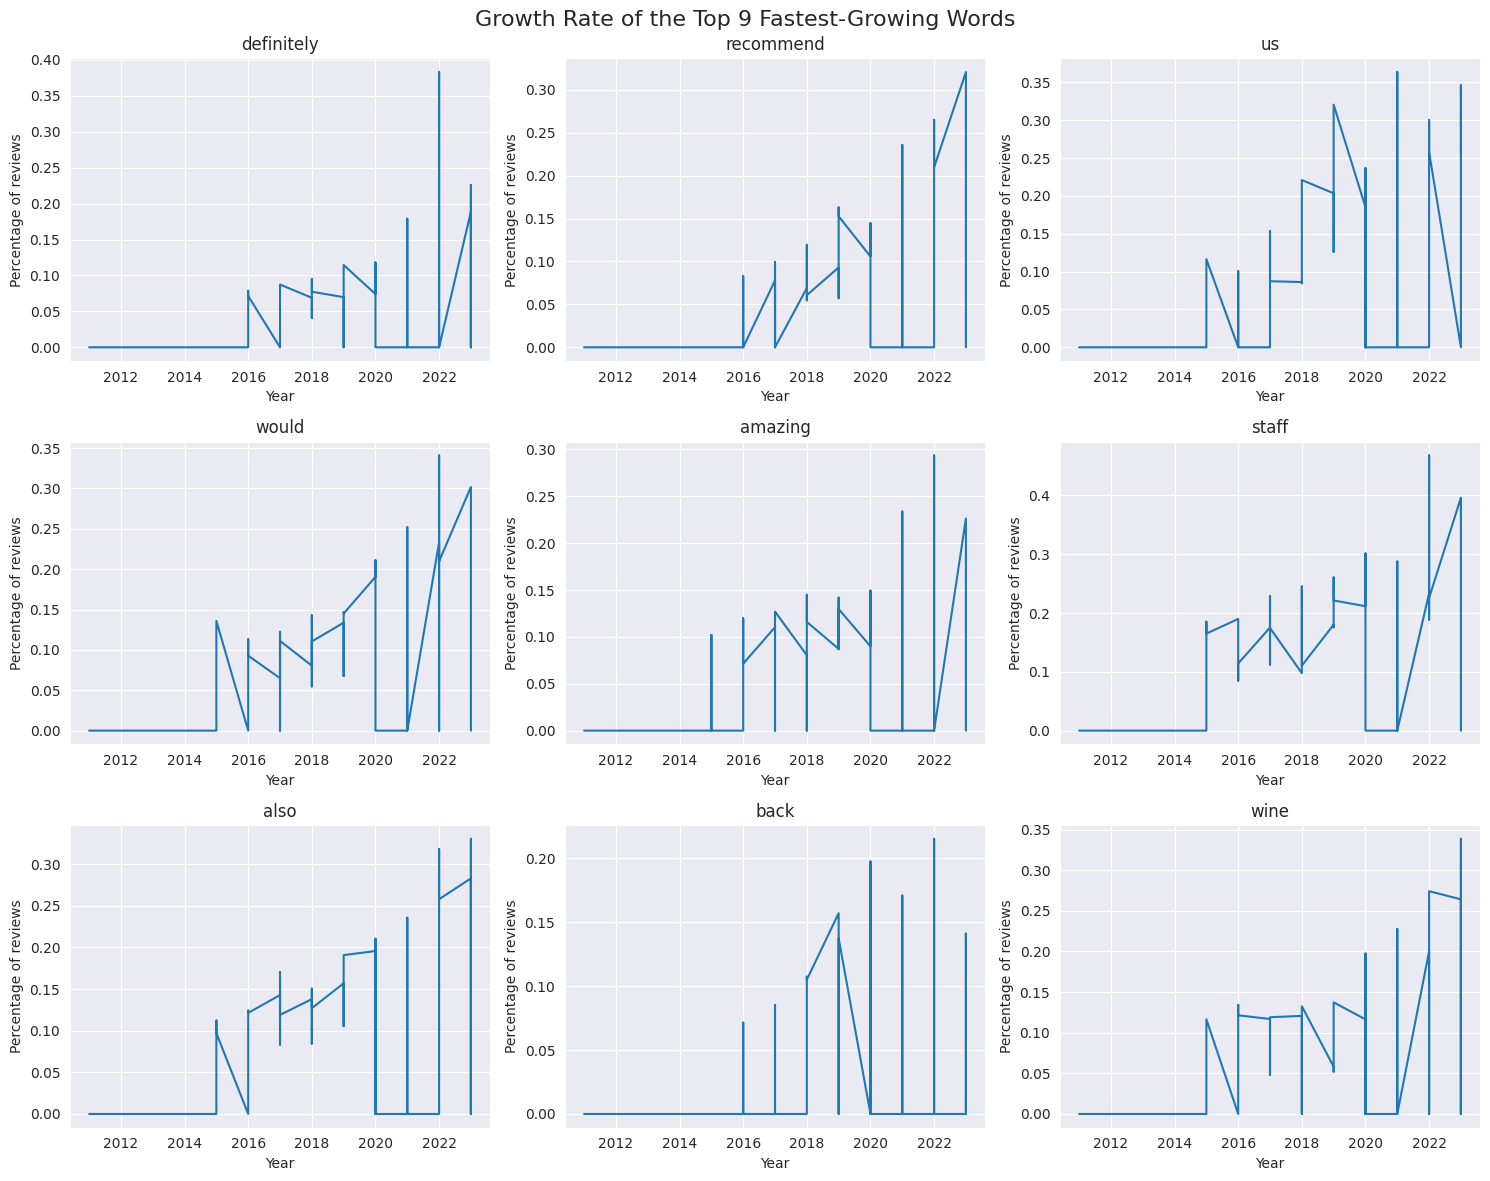

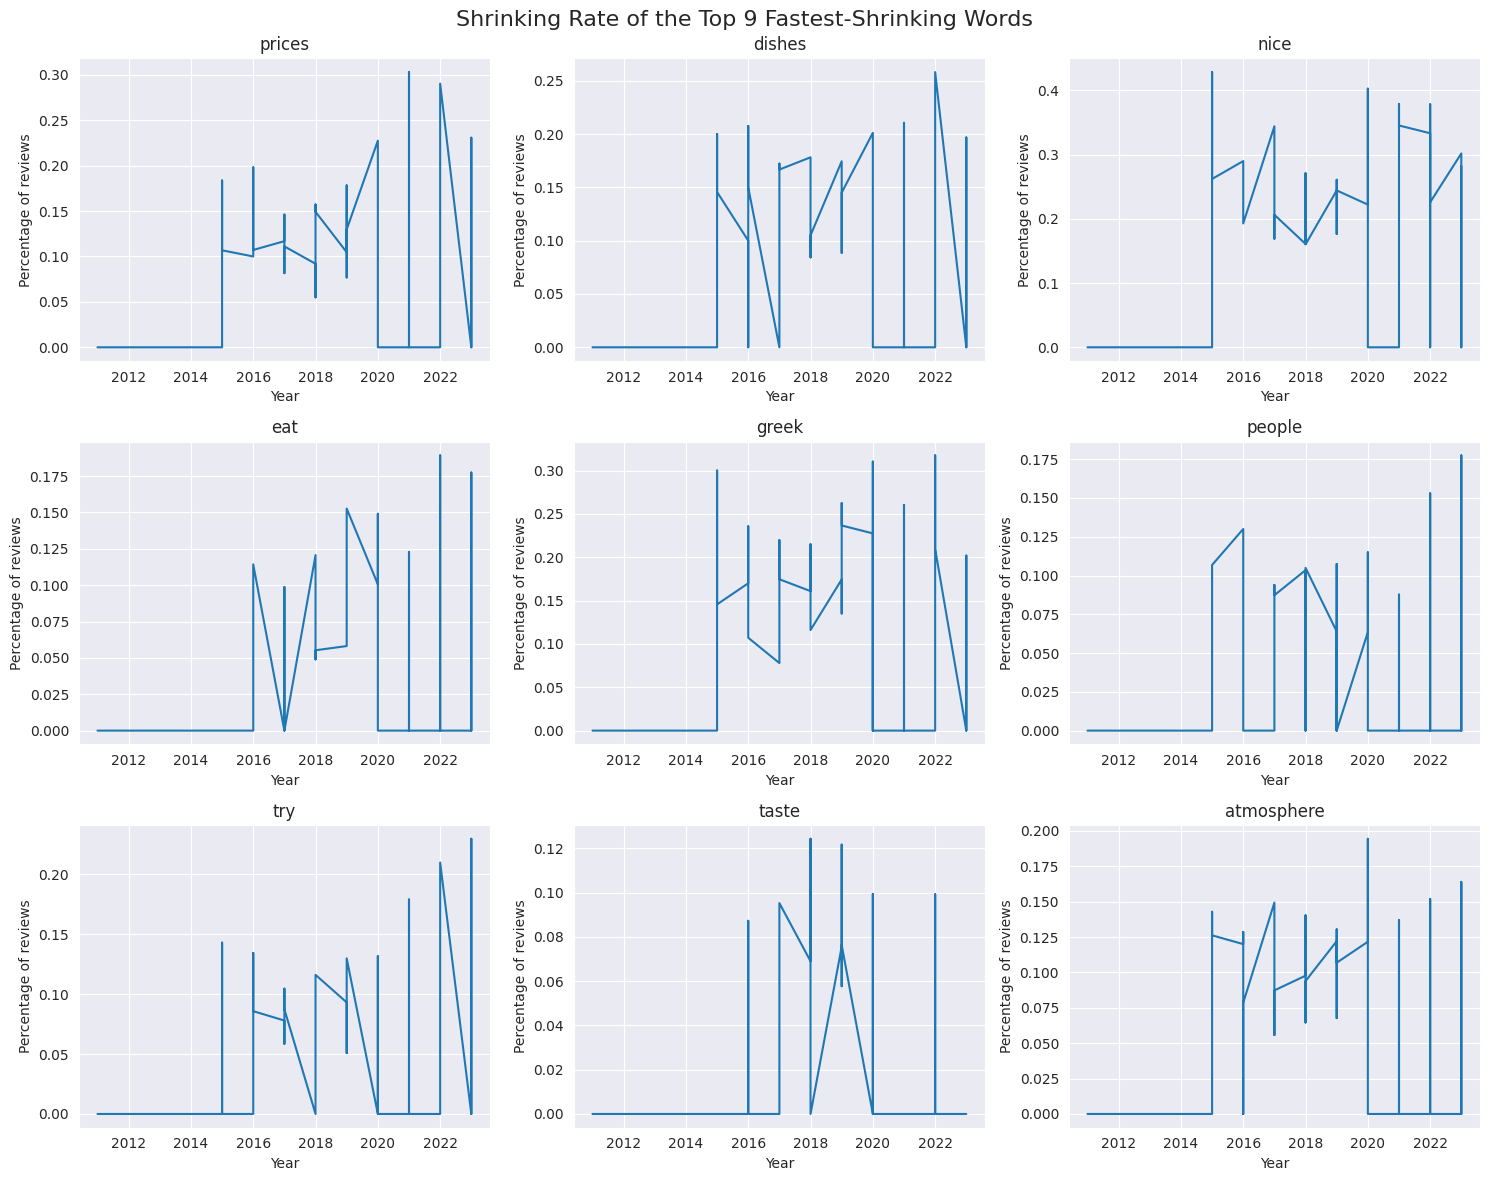

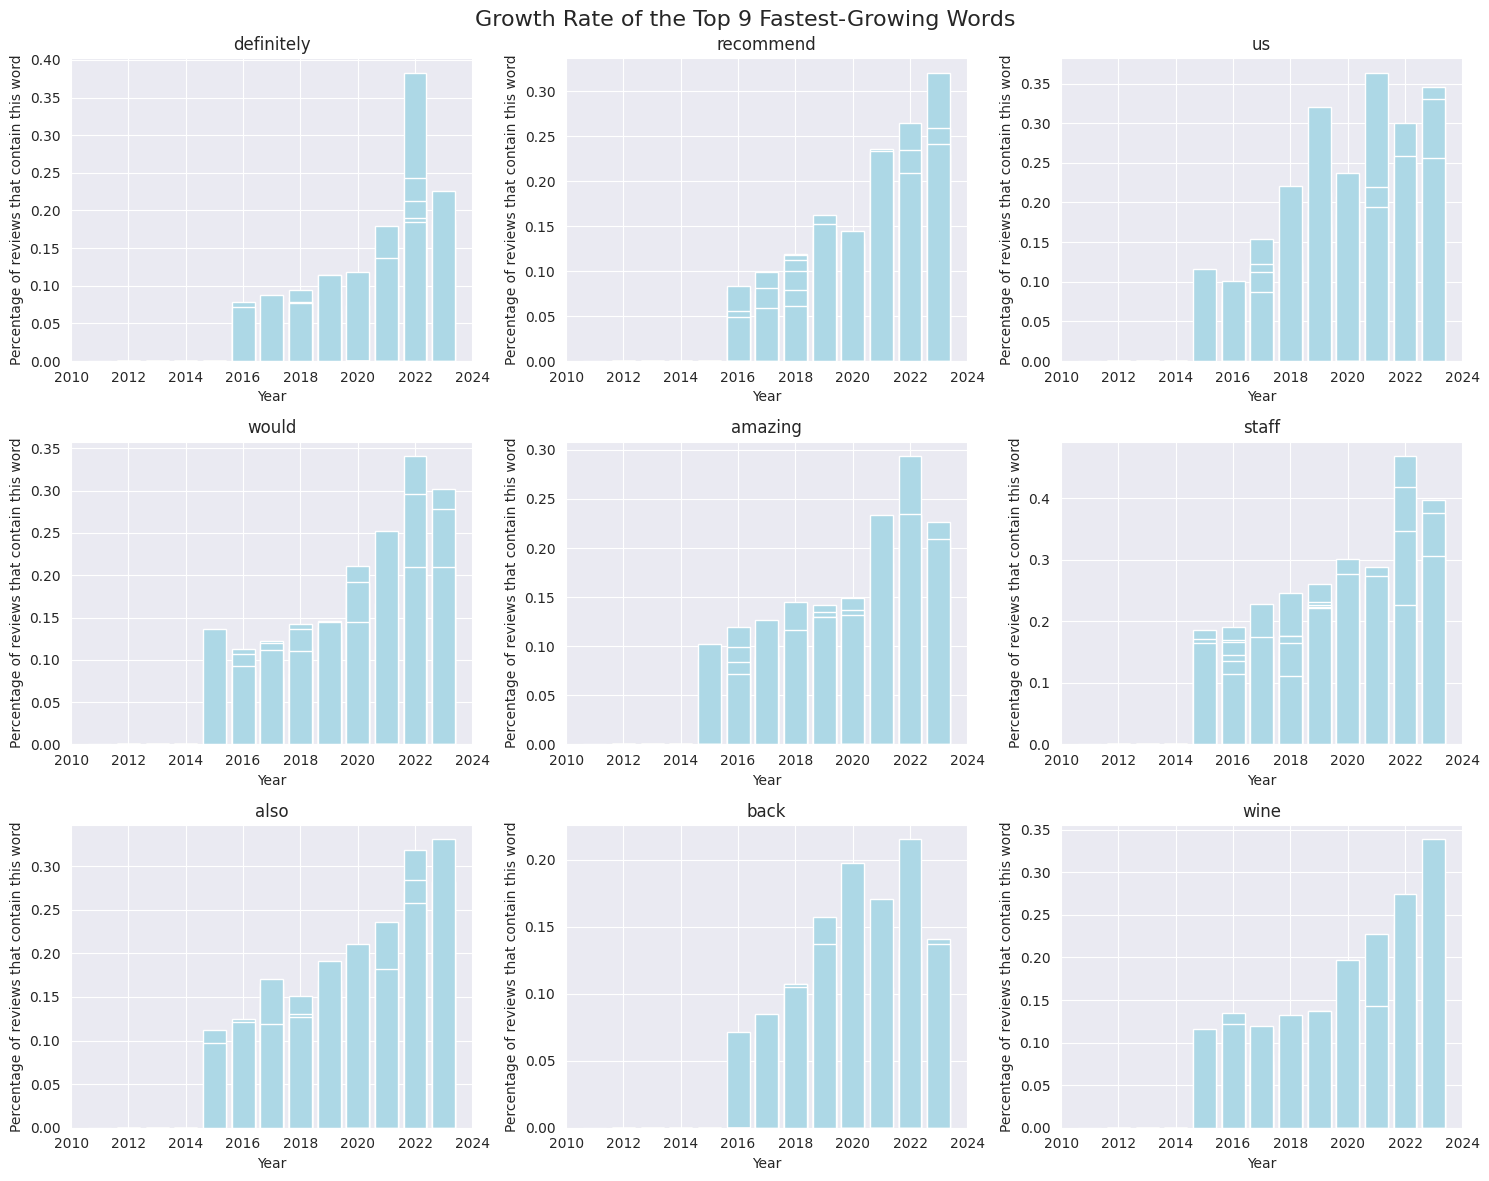

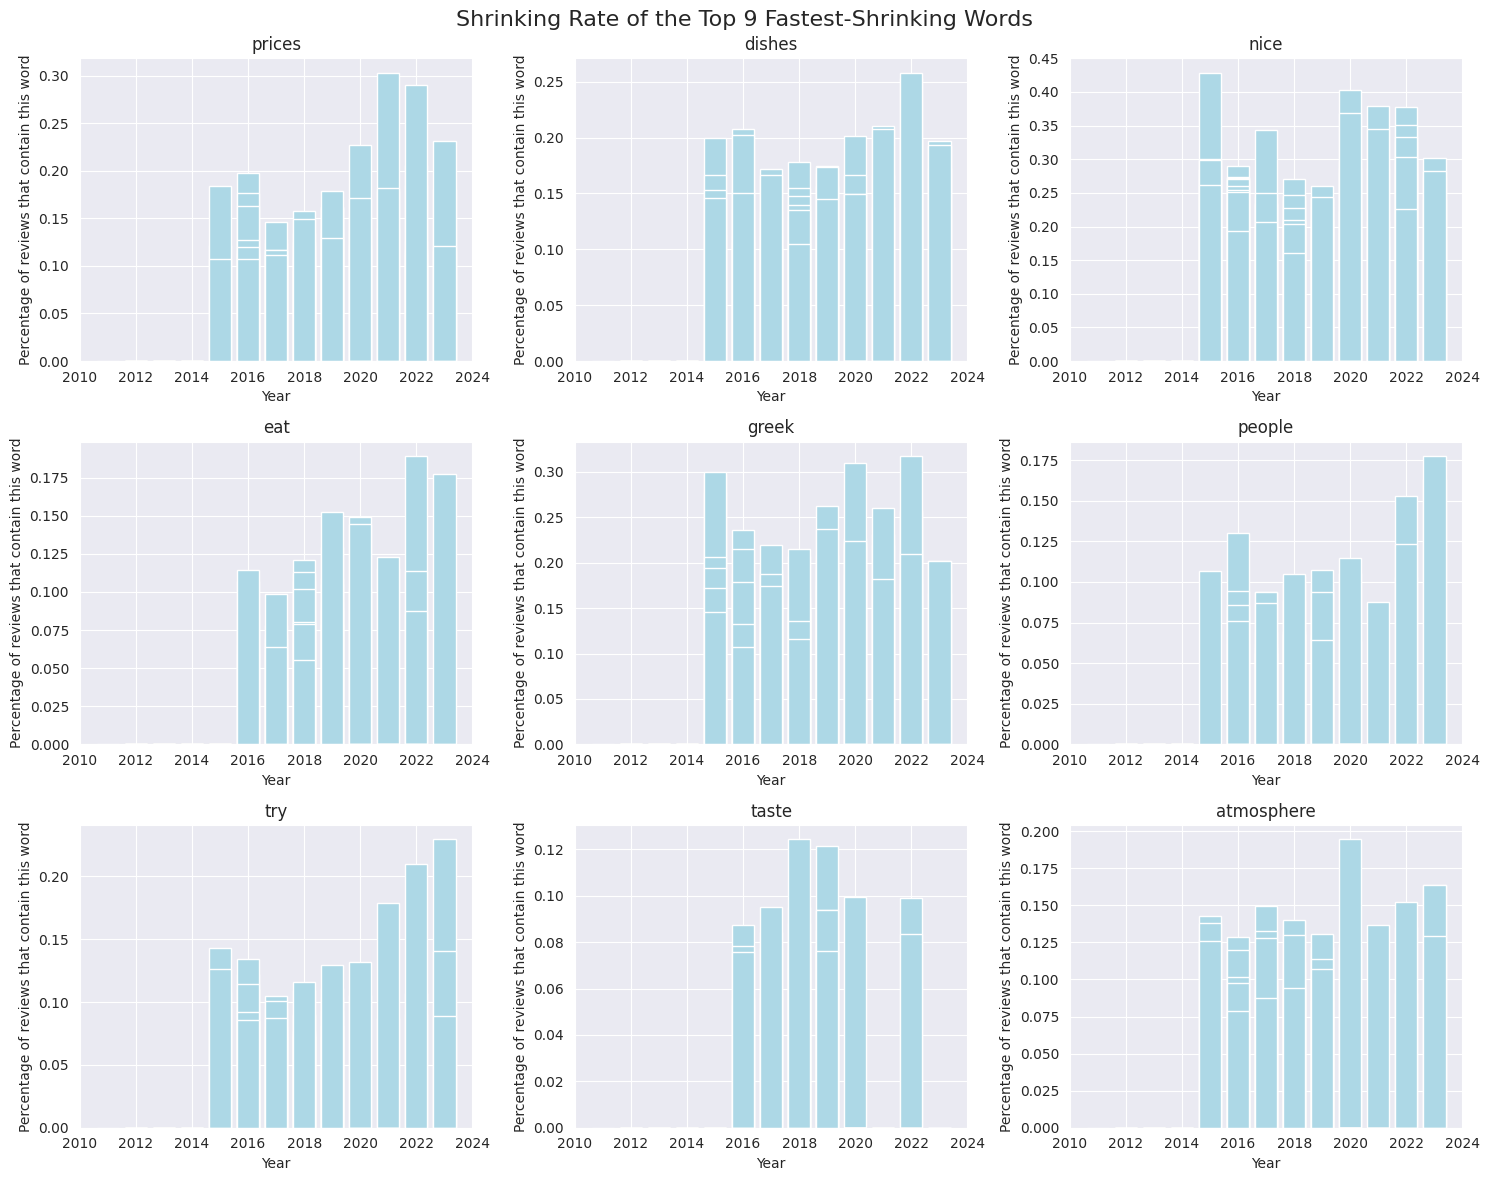

In [29]:
# Convert 'dateOfReview' column to datetime
df['dateOfReview'] = pd.to_datetime(df['dateOfReview'])
# print(df)

# Group the data by week and count the number of reviews per week
review_count_week = df.groupby(pd.Grouper(key='dateOfReview', freq='W')).size().reset_index(name='count')
# print(review_count_week)

# Plot the number of reviews per week
plt.figure(figsize=(12, 8))
sns.lineplot(data=review_count_week, x='dateOfReview', y='count')
plt.title('The Number of Reviews Per Week')
plt.xlabel('Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Round the 'dateOfReview' column to month
df['month'] = df['dateOfReview'].dt.to_period('M')
# print(df)

# Extract distinct review words
review_words = df[['_id', 'text', 'month']].drop_duplicates().reset_index(drop=True)

# Tokenize the review words
review_words['word'] = review_words['text'].str.lower().str.split()
#
# Explode the review words into separate rows
review_words = review_words.explode('word')

# Convert the 'word' column to string type
review_words['word'] = review_words['word'].astype(str)

# Remove numeric words
review_words = review_words[~review_words['word'].str.isnumeric()]
# print(review_words)

# Group by word and count the occurrences
word_counts = review_words.groupby('word').size().reset_index(name='count')

# Sort the word counts in descending order
word_counts = word_counts.sort_values('count', ascending=False)

# Plot the most common words
plt.figure(figsize=(12, 8))
sns.barplot(data=word_counts.head(25), x='count', y='word', color='lightblue')
plt.title('Most Common Words in Review Text')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

# Group the data by month and count the total reviews per month
reviews_per_month = df.groupby('month').size().reset_index(name='month_total')
# print(reviews_per_month)
# print(review_words)
#
# Filter words with total occurrences higher than 10
word_month_counts = review_words.groupby(['word', 'month']).size().reset_index(name='count')
# print(word_month_counts)
word_month_counts = word_month_counts[word_month_counts['count'] >= 10]
# print(word_month_counts)

# Fill missing combinations of word and month with 0 count
all_combinations = pd.MultiIndex.from_product([word_month_counts['word'].unique(), df['month'].unique()], names=['word', 'month'])
word_month_counts = word_month_counts.set_index(['word', 'month']).reindex(all_combinations, fill_value=0).reset_index()
# print(word_month_counts)

# Merge with the total number of reviews per month
word_month_counts = word_month_counts.merge(reviews_per_month, on='month')

# Calculate the percentage of word occurrences per month
word_month_counts['percent'] = word_month_counts['count'] / word_month_counts['month_total']

# Extract year from the 'month' column
word_month_counts['year'] = word_month_counts['month'].dt.year

####################################################
#filter 1
# Set the minimum occurrence threshold per year
min_occurrences_per_year = 200
# Group the data by word and year, and count the occurrences
review_words['year'] = review_words['month'].dt.year
word_year_counts = review_words.groupby(['word', 'year']).size().reset_index(name='count')
# Filter words that meet the minimum occurrence threshold per year
word_year_counts_filtered = word_year_counts.groupby('word').filter(lambda x: (x['count'] >= min_occurrences_per_year).any())
# Get the list of words that meet the threshold
filtered_words = word_year_counts_filtered['word'].unique()
# Filter the word_month_counts DataFrame based on the filtered words
word_month_counts_filtered = word_month_counts[word_month_counts['word'].isin(filtered_words)]

# Sort the word_month_counts dataframe by months
word_month_counts = word_month_counts.sort_values('month')
word_month_counts_filtered = word_month_counts_filtered.sort_values('month')

# print(word_month_counts)
# print(word_month_counts_filtered)
####################################################


# #############################
# #filter 2
# # Calculate the total number of reviews per month
# total_reviews_per_month = df.groupby('month').size().reset_index(name='total_reviews')
# # Merge the total_reviews_per_month with word_month_counts
# word_month_counts_merged = word_month_counts.merge(total_reviews_per_month, on='month')
# # Calculate the percentage of reviews containing each word for each month
# word_month_counts_merged['percent'] = word_month_counts_merged['count'] / word_month_counts_merged['total_reviews']
# # Filter words with at least 5% in the percent column for each month
# word_month_counts_filtered = word_month_counts_merged.groupby('word').filter(lambda x: (x['percent'] >= 0.01).all())
# print(word_month_counts)
# print(word_month_counts_filtered)
# ##################################

# Fit a logistic regression model for each word
models = {}
for word, data in word_month_counts_filtered.groupby('word'):
    formula = 'np.c_[percent] ~ year'
    model = glm(formula=formula, data=data, family=sm.families.Binomial())
    models[word] = model.fit()


# Extract the growth rate estimates for each word
slopes = pd.DataFrame({'word': models.keys(), 'estimate': [model.params['year'] for model in models.values()]})
slopes = slopes.sort_values('estimate', ascending=False)
# print(slopes)

# Select the top 9 fastest-growing words
top_9_growing = slopes.head(9)
# print(top_9_growing)
# Select the top 9 fastest-shrinking words
top_9_shrinking = slopes.tail(9)
# print(top_9_shrinking)

##############
# line plots


# Plot the growth rate of the top 9 fastest-growing words
plt.figure(figsize=(15, 12))
# Plot the growth rate of the top 9 fastest-growing words
for i, word in enumerate(top_9_growing['word']):
    data = word_month_counts[word_month_counts['word'] == word]
    ax = plt.subplot(3, 3, i+1)
    ax.plot(data['year'], data['percent'])
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of reviews')
    ax.set_title(word)

plt.suptitle('Growth Rate of the Top 9 Fastest-Growing Words', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 12))
# Plot the growth rate of the top 9 fastest-shrinking words
for i, word in enumerate(top_9_shrinking['word']):
    data = word_month_counts[word_month_counts['word'] == word]
    ax = plt.subplot(3, 3, i+1)
    ax.plot(data['year'], data['percent'])
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of reviews')
    ax.set_title(word)

plt.suptitle('Shrinking Rate of the Top 9 Fastest-Shrinking Words', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

###########################
#bar plots

# Plot the growth rate of the top 9 fastest-growing words as bar plots
plt.figure(figsize=(15, 12))
plt.title("top 9 fastest-growing words")
for i, word in enumerate(top_9_growing['word']):
    data = word_month_counts[word_month_counts['word'] == word]
    ax = plt.subplot(3, 3, i+1)
    ax.bar(data['year'], data['percent'], color='lightblue')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of reviews that contain this word')
    ax.set_title(word)

plt.suptitle('Growth Rate of the Top 9 Fastest-Growing Words', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Plot the growth rate of the top 9 fastest-shrinking words as bar plots
plt.figure(figsize=(15, 12))
for i, word in enumerate(top_9_shrinking['word']):
    data = word_month_counts[word_month_counts['word'] == word]
    ax = plt.subplot(3, 3, i+1)
    ax.bar(data['year'], data['percent'], color='lightblue')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of reviews that contain this word')
    ax.set_title(word)

plt.suptitle('Shrinking Rate of the Top 9 Fastest-Shrinking Words', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()



Visualization 6: Explore and visualize emerging topics from all the user reviews across time, similar
to here. Which topics do you identify? Do they make sense to you?

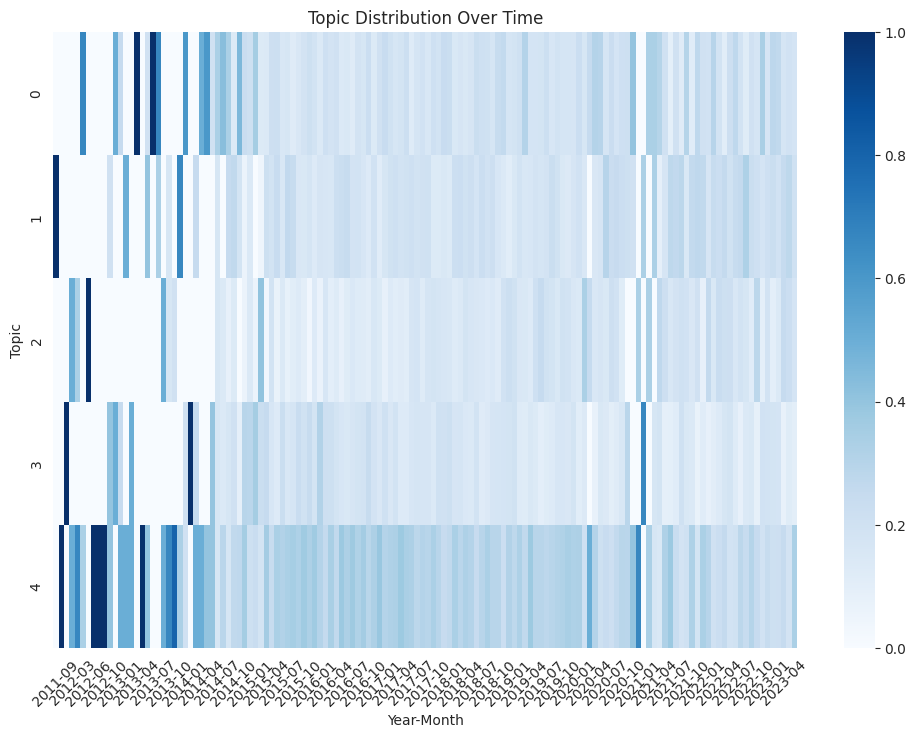

In [30]:
# Extra data preprocessing for this step
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

# Create the document-term matrix
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
dtm = vectorizer.fit_transform(df['processed_text'])

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

# Get the dominant topic for each document
topic_values = lda_model.transform(dtm)
df['dominant_topic'] = topic_values.argmax(axis=1)

# Topic distribution over time
# df['YearMonth'] = pd.to_datetime(df['YearMonth'], format='%Y-%m')
topic_distribution = df.groupby(['YearMonth', 'dominant_topic']).size().unstack().fillna(0)
topic_distribution = topic_distribution.div(topic_distribution.sum(axis=1), axis=0)

# Visualize the topic distribution over time
plt.figure(figsize=(12, 8))
sns.heatmap(topic_distribution.transpose(), cmap='Blues', cbar=True)
plt.title('Topic Distribution Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Topic')
plt.xticks(rotation=45)
plt.show()




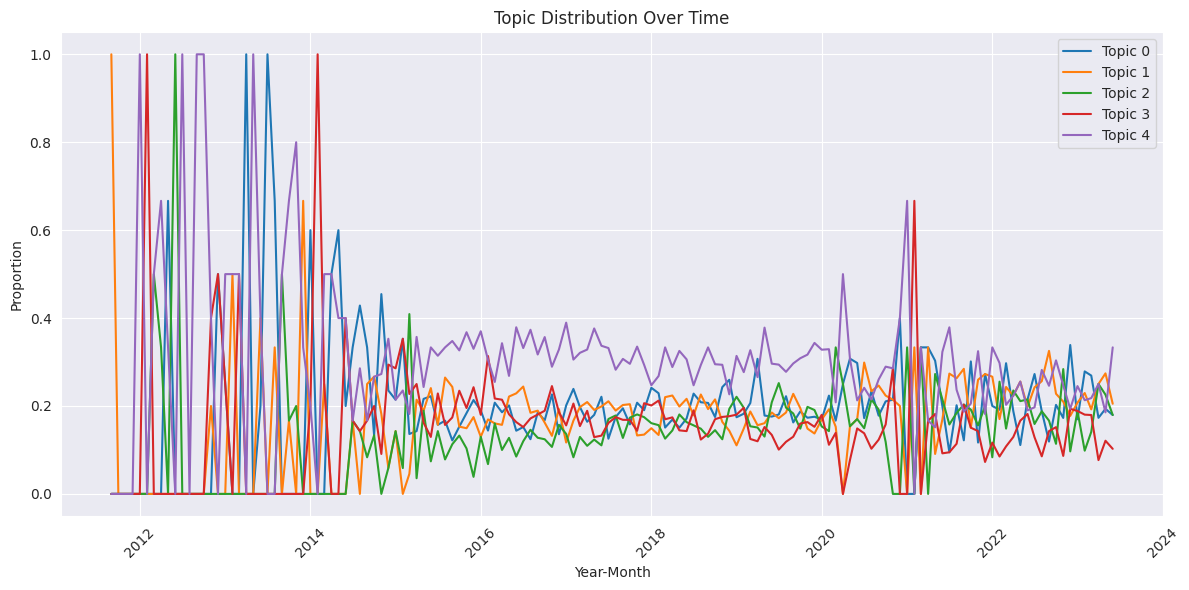

In [31]:
# Convert YearMonth to datetime
df['YearMonth'] = pd.to_datetime(df['YearMonth'].astype(str), format='%Y-%m')

# Topic distribution over time
topic_distribution = df.groupby(['YearMonth', 'dominant_topic']).size().unstack().fillna(0)
topic_distribution = topic_distribution.div(topic_distribution.sum(axis=1), axis=0)

# Reindex topic distribution to include all months
min_date = df['YearMonth'].min()
max_date = df['YearMonth'].max()
idx = pd.date_range(min_date, max_date, freq='MS')
topic_distribution = topic_distribution.reindex(idx, fill_value=0)

# Plotting topic distribution over time
plt.figure(figsize=(12, 6))
topics = topic_distribution.columns
for topic in topics:
    plt.plot(topic_distribution.index, topic_distribution[topic], label='Topic {}'.format(topic))

plt.title('Topic Distribution Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Proportion')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Top-10 keywords for Topic A:
place, good, staff, time, service, people, table, thessaloniki, came, night

Top-10 keywords for Topic B:
great, delicious, salad, greek, fresh, place, excellent, service, cheese, recommend

Top-10 keywords for Topic C:
thank, visit, place, great, thessaloniki, time, review, service, best, experience

Top-10 keywords for Topic D:
place, greek, good, quality, best, like, meat, dishes, wine, service

Top-10 keywords for Topic E:
good, nice, service, place, great, friendly, prices, staff, excellent, atmosphere



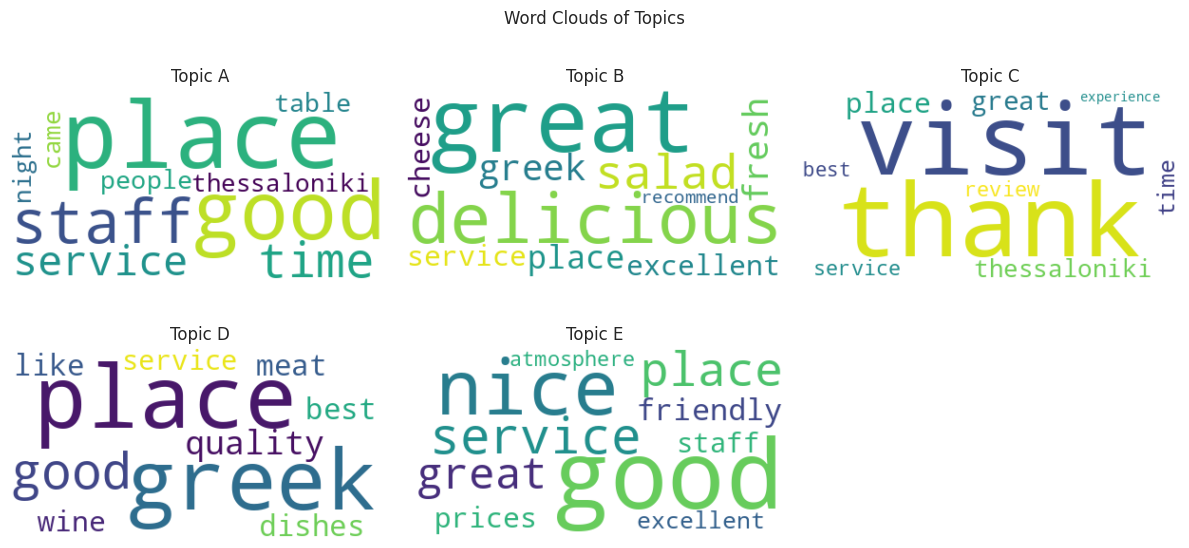

In [32]:
# Define the actual topic names
topic_names = ['Topic A', 'Topic B', 'Topic C', 'Topic D', 'Topic E']

# Generate word clouds for each topic
topics = lda_model.components_
feature_names = vectorizer.get_feature_names_out()

plt.figure(figsize=(12, 6))
num_topics = 5  # Change this to match the number of topics specified in LDA
num_top_keywords = 10  # Number of top keywords to display for each topic

for topic_idx, topic in enumerate(topics):
    word_scores = {feature_names[i]: topic[i] for i in topic.argsort()[:-11:-1]}
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_scores)
    plt.subplot(2, 3, topic_idx+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(topic_names[topic_idx])
    plt.axis('off')

    # Print top 10 keywords for the current topic
    top_terms = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Top-10 keywords for {topic_names[topic_idx]}:")
    print(", ".join(top_terms))
    print()

plt.suptitle('Word Clouds of Topics')
plt.tight_layout()
plt.show()
